# **Virus host detection**
Ezt a notebook-ot arra fogjuk használni, hogy egy-egy víruscsaládra vonatkozó adaton tanítsunk be minél jobb modellt. A legjobban teljesítő modelleket a notebook végén elmentjük, hogy majd újra felhasználjuk az aggregált modellünkben.

A modellekhez PyTorch-ot használunk, a dns szekvenciák feldolgozását pedig úgy valósítjuk meg, hogy azokat azonos hosszú részekre vágjuk.

**1. Szükséges package-k és import-ok**

In [2]:
pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot
from pyunpack import Archive
from sklearn.metrics import confusion_matrix
from tqdm.auto import trange, tqdm

**2. Adat előkészítése tanításra** \
Töltsük fel a korábban létrehozott 'filtered_sequences.7z' file-t, majd csomagoljuk ki.

In [5]:
Archive('filtered_sequences.7z').extractall("./")

Töltsük be a csv-t és adjunk hozzá néhány hasznos oszlopot.
A dns-eket nem karakterenként fogjuk elkódolni, hanem meghatározott hosszú részekre split-eljük, és azokat alakítjuk számokká.

In [3]:
df = pd.read_csv('filtered_sequences.csv')
df['sequence_length'] = df['dna_string'].str.len()

# split_len: a hossza egy dns részletnek
# overlap: a splitelés során megengedünk átfedést a részletek között, két szomszédos között pontosan ennyi lesz az átfedés
# Próbálkozások során a 6-hosszú és 2 ovarlap-es feldarabolás bizonyult a leghasznosabbnak
split_len = 6
overlap = 2
df['seq_batches'] = df.apply(lambda row: [row['dna_string'][i:i+split_len] for i in range(0, row['sequence_length'], split_len-overlap)], axis=1)
df

,dna_string,virus_id,is_host_human,sequence_length,seq_batches
0,ACGTGGACCGACAAGAACAGTTTCGACTCGGAAGCTTGCTTAACGT...,1,True,10695,"[ACGTGG, GGACCG, CGACAA, AAGAAC, ACAGTT, TTTCG..."
1,ATTCGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAGTTCTAACA...,1,True,10675,"[ATTCGA, GAACAG, AGTTTC, TCGAAT, ATCGGA, GAAGC..."
2,GAACAGTTTCGAATCGGAAGCTTGCTTAACGTAGTTCTAACAGTTT...,1,True,10669,"[GAACAG, AGTTTC, TCGAAT, ATCGGA, GAAGCT, CTTGC..."
3,ACAGTTTCGAATCGGAAGCTTGCTTAACGTAGTTCTAACAGTTTTT...,1,True,10656,"[ACAGTT, TTTCGA, GAATCG, CGGAAG, AGCTTG, TGCTT..."
4,ACGATAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAGTTCTG...,1,True,10689,"[ACGATA, TAAGAA, AACAGT, GTTTCG, CGAATC, TCGGA..."
...,...,...,...,...,...
140435,GTTGTTGATCTGTGTGAATCAGACTGCGACAGTTCGAGTTTGAAGC...,6,False,10776,"[GTTGTT, TTGATC, TCTGTG, TGTGAA, AATCAG, AGACT..."
140436,GCAATATTTGAAGAGGAAAAAGAGTGGAAGACTGCAGTGGAAGCTG...,6,True,402,"[GCAATA, TATTTG, TGAAGA, GAGGAA, AAAAAG, AGAGT..."
140437,ATGAAAAACCCAAAGAAGAAATCCGGAGGATTCCGGATTGTCAATA...,6,False,10269,"[ATGAAA, AAAACC, CCCAAA, AAGAAG, AGAAAT, ATCCG..."
140438,ATGAAAAACCCAAAGAAGAAATCCGGAGGATTCCGGATTGTCAATA...,6,True,10251,"[ATGAAA, AAAACC, CCCAAA, AAGAAG, AGAAAT, ATCCG..."


In [4]:
class WordTokenizer():
    def __init__(self, tok_seqs, threshold=50):
        tok_counts={}
        
        for tok_seq in tqdm(tok_seqs):
            for tok in tok_seq:
                if not tok in tok_counts.keys():
                    tok_counts[tok]=1
                else:
                    tok_counts[tok]+=1
        
        self.vocab={'[PAD]':0,'[UNK]':1}
        for tok, val in tok_counts.items():
            if val>=threshold:
                self.vocab[tok]=len(self.vocab)
                
        print("The size of the dictionary:",len(self.vocab))
    def encode(self,seq):
        encoded=[]
        for tok in seq:
            if tok in self.vocab.keys():
                encoded.append(self.vocab[tok])
            else:
                encoded.append(1)
        return encoded

In [5]:
# A szótárunk
word_tokenizer=WordTokenizer(df['seq_batches'])
df['encoded']=[word_tokenizer.encode(seq) for seq in tqdm(df['seq_batches'])]
df['encoded_length']=[len(seq) for seq in tqdm(df['seq_batches'])]

  0%|          | 0/140440 [00:00<?, ?it/s]

The size of the dictionary: 4461


  0%|          | 0/140440 [00:00<?, ?it/s]

  0%|          | 0/140440 [00:00<?, ?it/s]

In [6]:
sentiment_encoding={False:0, True:1}
df['encoded_sentiment']=[sentiment_encoding[sent] for sent in tqdm(df['is_host_human'])]
df

  0%|          | 0/140440 [00:00<?, ?it/s]

,dna_string,virus_id,is_host_human,sequence_length,seq_batches,encoded,encoded_length,encoded_sentiment
0,ACGTGGACCGACAAGAACAGTTTCGACTCGGAAGCTTGCTTAACGT...,1,True,10695,"[ACGTGG, GGACCG, CGACAA, AAGAAC, ACAGTT, TTTCG...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",2674,1
1,ATTCGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAGTTCTAACA...,1,True,10675,"[ATTCGA, GAACAG, AGTTTC, TCGAAT, ATCGGA, GAAGC...","[1705, 370, 1706, 1707, 1708, 254, 1709, 1710,...",2669,1
2,GAACAGTTTCGAATCGGAAGCTTGCTTAACGTAGTTCTAACAGTTT...,1,True,10669,"[GAACAG, AGTTTC, TCGAAT, ATCGGA, GAAGCT, CTTGC...","[370, 1706, 1707, 1708, 254, 1709, 1710, 280, ...",2668,1
3,ACAGTTTCGAATCGGAAGCTTGCTTAACGTAGTTCTAACAGTTTTT...,1,True,10656,"[ACAGTT, TTTCGA, GAATCG, CGGAAG, AGCTTG, TGCTT...","[6, 7, 2500, 9, 10, 11, 12, 1590, 2501, 15, 16...",2664,1
4,ACGATAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAGTTCTG...,1,True,10689,"[ACGATA, TAAGAA, AACAGT, GTTTCG, CGAATC, TCGGA...","[1577, 454, 15, 2986, 2987, 2462, 2988, 804, 5...",2673,1
...,...,...,...,...,...,...,...,...
140435,GTTGTTGATCTGTGTGAATCAGACTGCGACAGTTCGAGTTTGAAGC...,6,False,10776,"[GTTGTT, TTGATC, TCTGTG, TGTGAA, AATCAG, AGACT...","[1246, 359, 2621, 2690, 2183, 3185, 1391, 6, 2...",2694,0
140436,GCAATATTTGAAGAGGAAAAAGAGTGGAAGACTGCAGTGGAAGCTG...,6,True,402,"[GCAATA, TATTTG, TGAAGA, GAGGAA, AAAAAG, AGAGT...","[522, 1212, 1296, 1529, 94, 1084, 223, 3185, 2...",101,1
140437,ATGAAAAACCCAAAGAAGAAATCCGGAGGATTCCGGATTGTCAATA...,6,False,10269,"[ATGAAA, AAAACC, CCCAAA, AAGAAG, AGAAAT, ATCCG...","[345, 29, 2122, 423, 1080, 896, 937, 3075, 292...",2568,0
140438,ATGAAAAACCCAAAGAAGAAATCCGGAGGATTCCGGATTGTCAATA...,6,True,10251,"[ATGAAA, AAAACC, CCCAAA, AAGAAG, AGAAAT, ATCCG...","[345, 29, 2122, 423, 1080, 896, 937, 3075, 292...",2563,1


**3. Tanító adatok szétválasztása**

Vírusonként szétválasztjuk az adatokat egy training, test és validációs adathalmazra 80:10:10 arányban.

In [7]:
# Először megkeverjük az adathalmazt
df = df = df.sample(frac=1, random_state=41).reset_index(drop=True)


dengue_df = df[df["virus_id"] == 1]
size = len(dengue_df.index)

dengue_train = dengue_df[:int(0.8 * size)]
dengue_test = dengue_df[int(0.8 * size):int(0.9 * size)]
dengue_valid = dengue_df[int(0.9 * size):]


ebola_df = df[df["virus_id"] == 2]
size = len(ebola_df.index)

ebola_train = ebola_df[:int(0.8 * size)]
ebola_test = ebola_df[int(0.8 * size):int(0.9 * size)]
ebola_valid = ebola_df[int(0.9 * size):]


mers_df = df[df["virus_id"] == 3]
size = len(mers_df.index)

mers_train = mers_df[:int(0.8 * size)]
mers_test = mers_df[int(0.8 * size):int(0.9 * size)]
mers_valid = mers_df[int(0.9 * size):]


rota_df = df[df["virus_id"] == 4]
size = len(rota_df.index)

rota_train = rota_df[:int(0.8 * size)]
rota_test = rota_df[int(0.8 * size):int(0.9 * size)]
rota_valid = rota_df[int(0.9 * size):]


west_nile_df = df[df["virus_id"] == 5]
size = len(west_nile_df.index)

west_nile_train = west_nile_df[:int(0.8 * size)]
west_nile_test = west_nile_df[int(0.8 * size):int(0.9 * size)]
west_nile_valid = west_nile_df[int(0.9 * size):]


zika_df = df[df["virus_id"] == 6]
size = len(zika_df.index)

zika_train = zika_df[:int(0.8 * size)]
zika_test = zika_df[int(0.8 * size):int(0.9 * size)]
zika_valid = zika_df[int(0.9 * size):]

# Eltávolítjuk a temp dataframe-eket
del dengue_df
del ebola_df
del mers_df
del rota_df
del west_nile_df
del zika_df

Hogy elkerüljük azt, hogy kiegyensúlyozatlan training data-val dolgozzunk, random undersampling-et alkalmazunk.

In [8]:
under = RandomUnderSampler(sampling_strategy=0.9, random_state=1)

size_original = len(dengue_train.index)
dengue_train, _ = under.fit_resample(dengue_train, dengue_train["encoded_sentiment"])
size_undersampled = len(dengue_train.index)
print("Dengue: original train sample size {}, after undersampling {}".format(size_original, size_undersampled))

size_original = len(ebola_train.index)
ebola_train, _ = under.fit_resample(ebola_train, ebola_train["encoded_sentiment"])
size_undersampled = len(ebola_train.index)
print("Ebola: original train sample size {}, after undersampling {}".format(size_original, size_undersampled))

size_original = len(mers_train.index)
mers_train, _ = under.fit_resample(mers_train, mers_train["encoded_sentiment"])
size_undersampled = len(mers_train.index)
print("MERS: original train sample size {}, after undersampling {}".format(size_original, size_undersampled))

size_original = len(rota_train.index)
rota_train, _ = under.fit_resample(rota_train, rota_train["encoded_sentiment"])
size_undersampled = len(rota_train.index)
print("Rota: original train sample size {}, after undersampling {}".format(size_original, size_undersampled))

size_original = len(west_nile_train.index)
west_nile_train, _ = under.fit_resample(west_nile_train, west_nile_train["encoded_sentiment"])
size_undersampled = len(west_nile_train.index)
print("West-Nile: original train sample size {}, after undersampling {}".format(size_original, size_undersampled))

size_original = len(zika_train.index)
zika_train, _ = under.fit_resample(zika_train, zika_train["encoded_sentiment"])
size_undersampled = len(zika_train.index)
print("Zika: original train sample size {}, after undersampling {}".format(size_original, size_undersampled))

Dengue: original train sample size 24736, after undersampling 1621
Ebola: original train sample size 2034, after undersampling 494
MERS: original train sample size 1040, after undersampling 952
Rota: original train sample size 79784, after undersampling 29785
West-Nile: original train sample size 3720, after undersampling 1213
Zika: original train sample size 1036, after undersampling 504


**4. Modellek**

A tanítás során 4 modelt próbáltam ki különböző hiperparaméterekkel: LSTM, Bidirectional LSTM, GRU és CNN (1dConv).

In [9]:
class LSTMNet(nn.Module):
    def __init__(self, params):
        super(LSTMNet, self).__init__()
        
        default_params={
            "embedding_dim":50,
            "lstm_hidden_dim":100,
            "number_of_tags":2,
            "num_layers":1,
            "dropout": 0,
            "bidirectional": False
        }
        for key in default_params:
            params[key] = params.get(key, default_params[key])
        
        self.embedding = nn.Embedding(params["vocab_size"], params["embedding_dim"])

        self.lstm = nn.LSTM(params["embedding_dim"],
                            params["lstm_hidden_dim"],
                            batch_first = True,
                            num_layers = params["num_layers"],
                            dropout = params["dropout"],
                            bidirectional = params["bidirectional"])

        self.fc = nn.Linear(params["lstm_hidden_dim"], params["number_of_tags"])

    def forward(self, batch):
        emb = self.embedding(batch)
        
        output, (h_t, c_t) = self.lstm(emb)
            
        out = self.fc(h_t).float()[0]
        
        return out
 



In [10]:
class GRUNet(nn.Module):
    def __init__(self, params):
        super(GRUNet, self).__init__()

        default_params={
            "embedding_dim":50,
            "gru_hidden_dim":100,
            "number_of_tags":2,
            "num_layers":1,
            "dropout": 0
        }
        for key in default_params:
            params[key] = params.get(key, default_params[key])

        self.embedding = nn.Embedding(params["vocab_size"], params["embedding_dim"])
        
        self.gru = nn.GRU(params["embedding_dim"],
                          params["gru_hidden_dim"],
                          num_layers = params["num_layers"],
                          batch_first=True,
                          dropout=params["dropout"])
        self.fc = nn.Linear(params["gru_hidden_dim"], params["number_of_tags"])
        # self.relu = nn.ReLU()
        
    def forward(self, batch):
        emb = self.embedding(batch)

        output, h_t = self.gru(emb)

        out = self.fc(h_t).float()[0]
        
        return out

In [11]:
class Conv1dNet(nn.Module):
    def __init__(self, params):
        super(Conv1dNet, self).__init__()
        
        default_params={
            "embedding_dim":50,
            "feature_size":20,
            "window_sizes":[3,5,7,9],
            "number_of_tags": 2,
            "dropout": 0
        }
        for key in default_params:
            params[key] = params.get(key, default_params[key])
        
        self.dropout_rate = params["dropout"]
        
        self.embedding = nn.Embedding(params["vocab_size"], params["embedding_dim"])
        
        self.convs = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=params["embedding_dim"], 
                                        out_channels=params["feature_size"], 
                                        kernel_size=h),
                              nn.BatchNorm1d(num_features=params["feature_size"]), 
                              nn.ReLU(),
                              nn.AdaptiveMaxPool1d(1))
                              # nn.AdaptiveAvgPool1d(1))
                     for h in params["window_sizes"]])

        self.fc = nn.Linear(params["feature_size"]*len(params["window_sizes"]), params["number_of_tags"])

    def forward(self, batch):
        emb = self.embedding(batch)
        emb = emb.permute(0, 2, 1)
        
        output = [conv(emb) for conv in self.convs]
        out = torch.cat(output, dim=1)
        out = out.view(-1, out.size(1)) 
        
        out = F.dropout(input=out, p=self.dropout_rate)
        out = self.fc(out)
        return out

In [ ]:
# Egy ilyen layerrel is kísérleteztem kicsit, de nem tűnt jó modellnek
class CNN_LSTM_Net(nn.Module):
    def __init__(self, params):
        super(CNN_LSTM_Net, self).__init__()

        default_params={
            "embedding_dim":50,
            "feature_size":20,
            "window_sizes":[3,5,7,9],
            "number_of_tags": 2,

            "lstm_hidden_dim":100,
            "num_layers":1,
            "bidirectional": False,

            "dropout": 0
        }
        for key in default_params:
            params[key] = params.get(key, default_params[key])
        
        self.embedding = nn.Embedding(params["vocab_size"], params["embedding_dim"])

        self.dropout_rate = params["dropout"]
        
        self.convs = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=params["embedding_dim"], 
                                        out_channels=params["feature_size"], 
                                        kernel_size=h),
                              nn.BatchNorm1d(num_features=params["feature_size"]), 
                              nn.ReLU(),
                              nn.AdaptiveMaxPool1d(1))
                     for h in params["window_sizes"]])
        
        self.embedding2 = nn.Embedding(params["feature_size"]*len(params["window_sizes"]), params["embedding_dim"])
        
        self.lstm = nn.LSTM(params["embedding_dim"],
                            params["lstm_hidden_dim"],
                            batch_first = True,
                            num_layers = params["num_layers"],
                            bidirectional = params["bidirectional"])

        self.fc = nn.Linear(params["lstm_hidden_dim"], params["number_of_tags"])
        
    def forward(self, batch):
        emb = self.embedding(batch)
        emb = emb.permute(0, 2, 1)

        dropout = F.dropout(input=emb, p=self.dropout_rate)
        
        conv1_output = [conv(dropout) for conv in self.convs]
        c1 = torch.cat(conv1_output, dim=1)
        c1 = c1.view(-1, c1.size(1))

        emb2 = self.embedding2(c1.long())

        output, (h_t, c_t) = self.lstm(emb2)
        out = self.fc(h_t).float()[0]
        
        return out

**5. Tanítás**

Néhány függvény a tanításhoz.

In [12]:
use_cuda = torch.cuda.is_available()
def to_cuda(var):
    if use_cuda:
        return var.cuda()
    return var

def batch_iterator(df, batch_size, shuffle=True):
    if batch_size==0:
        starts=[0]
        batch_size=len(df)
    else:
        starts=np.arange(0, len(df), batch_size)
        if shuffle:
            np.random.shuffle(starts)

    for start in starts:
        batch = df[start:start+batch_size]
        bs = min(batch_size,len(df)-start)
        
        batch_len = batch["encoded_length"].max() 
            
        input_tensor = torch.zeros((bs, batch_len)).long()
        
        for idx, (seq, seq_len) in enumerate(zip(list(batch["encoded"]),list(batch["encoded_length"]))):
            input_tensor[idx, :seq_len] = torch.LongTensor(seq)

        sentiment_tensor = torch.LongTensor(list(batch["encoded_sentiment"]))

        yield to_cuda(input_tensor), to_cuda(sentiment_tensor)

In [13]:
def general_plot(ys, xlabel="", ylabel="", title="", size=(5,5), labels=[]):
    pyplot.rcParams["figure.figsize"] = [size[1], size[0]]

    ax = pyplot.subplot(111)
    if labels==[]:
        for y in ys:
            print(range(len(y)), y)
            pyplot.plot(range(len(y)), y, marker='.')
    else:
        for i in range(len(ys)):
            pyplot.plot(range(len(ys[i])), ys[i], marker='.', label=labels[i])
        ax.legend()
    ax.tick_params(axis='x', colors='#0B98C8')
    ax.tick_params(axis='y', colors='#0B98C8')
    ax.yaxis.label.set_color('#0B98C8')
    ax.xaxis.label.set_color('#0B98C8')
    ax.set_facecolor('#293340')
    ax.title.set_color('#0B98C8')
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.title(title)
    
    pyplot.xticks([i+1 for i in range(len(ys[0])) if  i % max(int(len(ys[0]) / (2*size[1])),1)==0])

    pyplot.show()

def plot_confusion_matrix(cm, title):
    ax = pyplot.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted host')
    ax.set_ylabel('True host')
    ax.set_title(title);
    ax.xaxis.set_ticklabels(['non-human', 'human']); ax.yaxis.set_ticklabels(['non-human', 'human'])

    pyplot.show()

In [14]:
class RunningAverage():
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        if self.steps==0:
            return 0
        else:
            return self.total / float(self.steps)

def classify(output):
    res=[]
    for p in output:
        res.append(np.argmax(p))
    return res

def get_results(model, iterator):
    res=[]
    sent=[]
    for input_batch, sentiment in iterator:
        output_batch = model(input_batch)
        result = classify(output_batch.data.cpu().numpy())

        res += result
        sent += list(sentiment.cpu().numpy().reshape(len(input_batch)))
    return res, sent

def get_accuracy(results, labels):
    correct = np.sum(np.equal(labels, results))
    alles = len(labels)
            
    return correct/alles*100
      
# Adam optimizer-t és CrossEntropyLoss veszteség függvényt használunk
def train(model, train_df, test_df, batch_size, epochs):    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()
        
    avg_losses=[]
    train_accuracies=[]
    test_accuracies=[]
    train_acc = 0
    test_acc = 0
    
    t = trange(epochs)
    for i in t:        
        #-----TRAINING-----
        model.train()
        loss_avg = RunningAverage()
        
        for input_batch, sentiment in batch_iterator(train_df, batch_size):
            output_batch = model(input_batch)

            loss = loss_fn(output_batch, sentiment)
            loss_avg.update(loss.item())

            loss.backward()

            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()
            t.set_postfix(accOnTrain="{:05.2f}%".format(train_acc), accOnTest='{:05.2f}%'.format(test_acc), loss='{:05.3f}'.format(loss_avg()))
            
        avg_losses.append(loss_avg())
      
        #-----EVALUATING-----
        model.eval()
        
        train_results, train_sentiments = get_results(model, batch_iterator(train_df, batch_size, shuffle=False))
        train_acc = get_accuracy(train_results, train_sentiments)
        train_accuracies.append(train_acc) 
        train_conf = confusion_matrix(train_sentiments, train_results)

        test_results, test_sentiments = get_results(model, batch_iterator(test_df, batch_size, shuffle=False))
        test_acc = get_accuracy(test_results, test_sentiments)
        test_accuracies.append(test_acc)
        test_conf = confusion_matrix(test_sentiments, test_results)

        t.set_postfix(accOnTrain="{:05.2f}%".format(train_acc), accOnTest='{:05.2f}%'.format(test_acc), loss='{:05.3f}'.format(loss_avg()))
    
    general_plot([avg_losses], 'epoch', 'loss', 'Average loss of each epoch', (8,15))
    general_plot([train_accuracies,test_accuracies], 'epoch', 'accuracy', 'Accuracy after each epoch', (8,15), ['train acc','test acc'])
    plot_confusion_matrix(train_conf, 'Train Confusion Matrix')
    plot_confusion_matrix(test_conf, 'Test Confusion Matrix')
    return test_accuracies

A tényleges tanítás innen indul, a legjobb modelleket megőrzöm a notebookban.

Legjobb dengue modellek

  0%|          | 0/10 [00:00<?, ?it/s]

range(0, 10) [0.6083906448403725, 0.5353273903134562, 0.47358157428018244, 0.4159711585470571, 0.381909365966714, 0.3492379773690385, 0.2822548794672387, 0.25437620720302434, 0.22474829593129886, 0.20921643092254671]


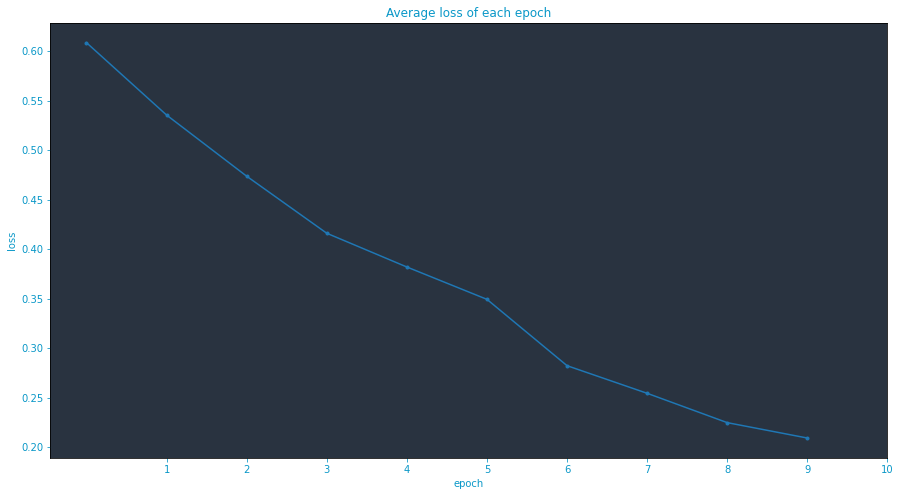

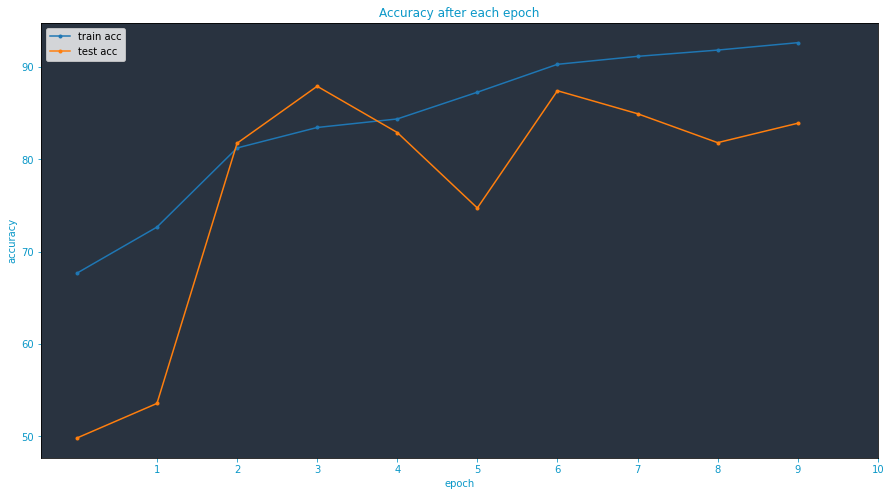

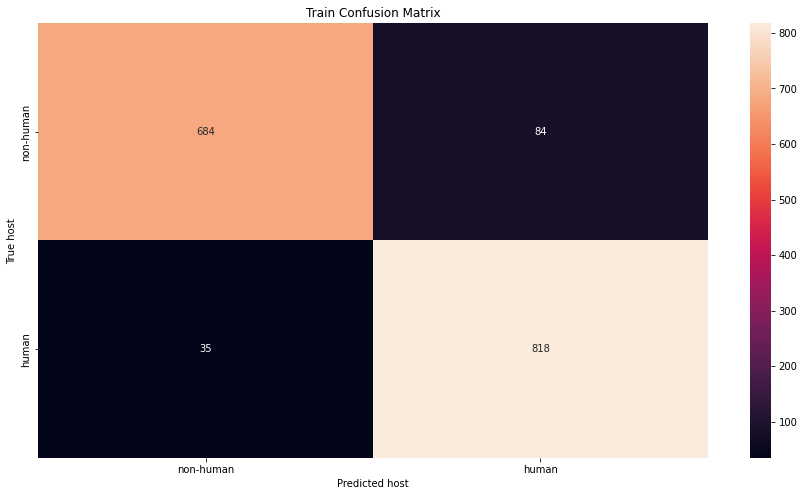

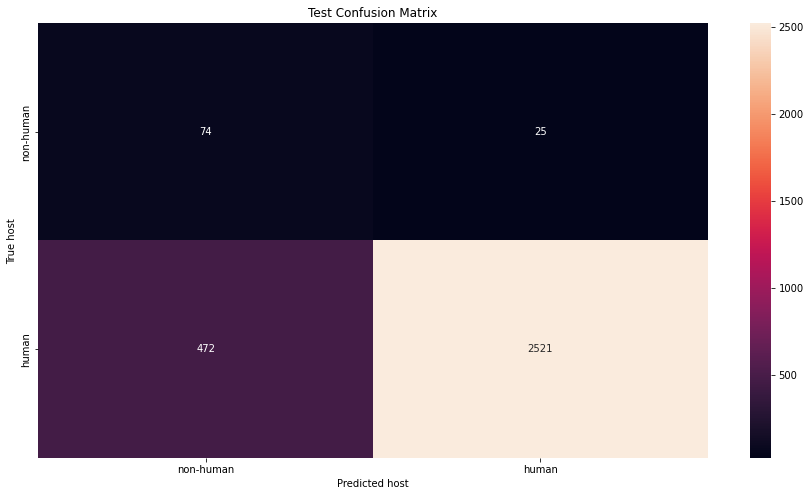

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": False
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, dengue_train, dengue_test, batch_size=2, epochs=10)
torch.save(lstm_model, 'dengue_lstm.pth')
del lstm_model

  0%|          | 0/10 [00:00<?, ?it/s]

range(0, 10) [0.5846120773380538, 0.401294771635, 0.27951669819610975, 0.22301464371700283, 0.20154418636079097, 0.182946684157733, 0.16650465785389157, 0.16367906910494096, 0.156730722653331, 0.14807131559355946]


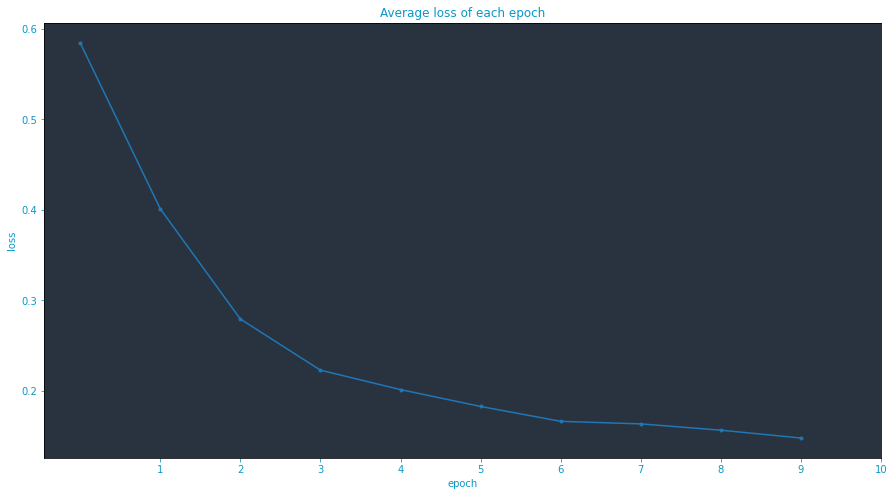

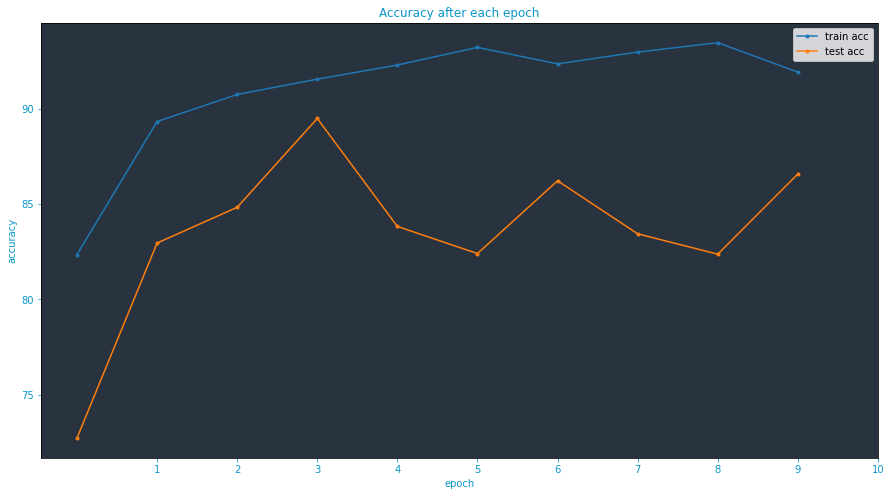

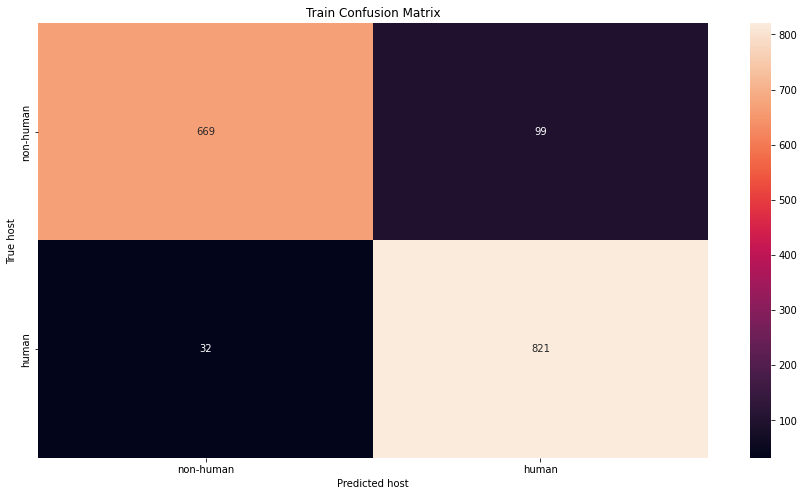

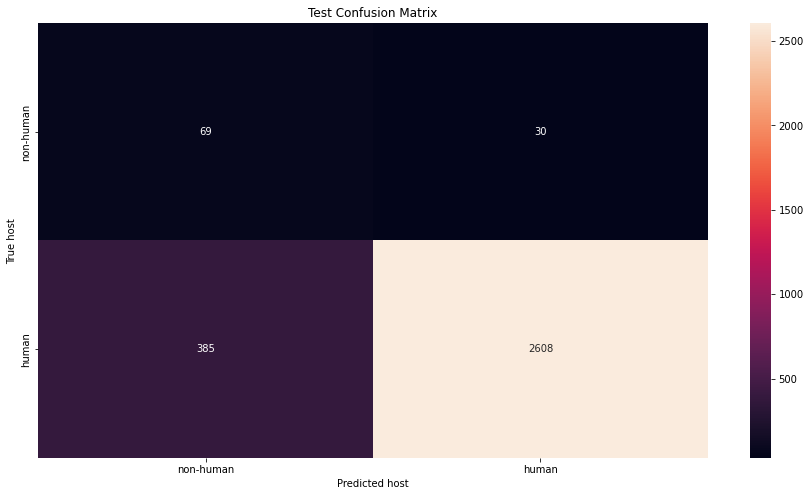

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 200,
        "lstm_hidden_dim": 100,
        "number_of_tags": 2,
        "num_layers": 3,
        "dropout": 0.2,
        "bidirectional": True
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, dengue_train, dengue_test, batch_size=2, epochs=10)
torch.save(lstm_model, 'dengue_bilstm.pth')
del lstm_model

  0%|          | 0/10 [00:00<?, ?it/s]

range(0, 10) [0.610139025963209, 0.5261591831199209, 0.3900919877183331, 0.28699670491956, 0.24844067489484878, 0.21707065267897177, 0.19709671458148176, 0.19088484854464685, 0.1887731222639236, 0.17041939777094164]


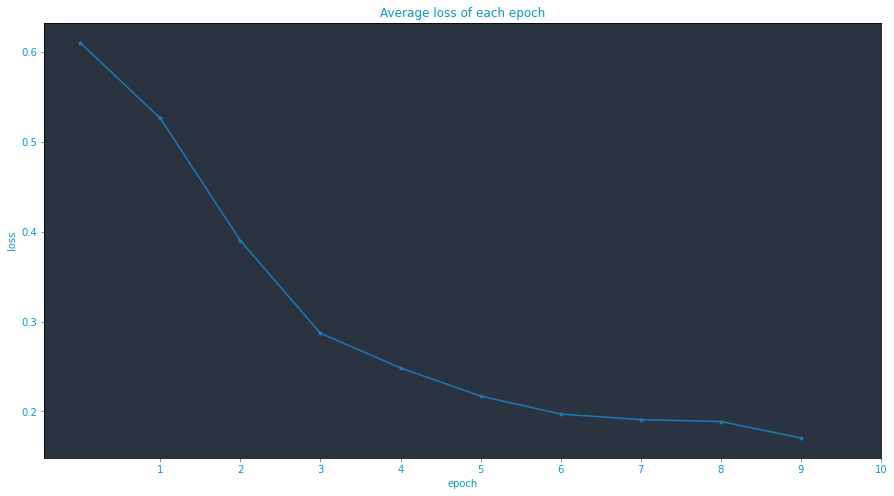

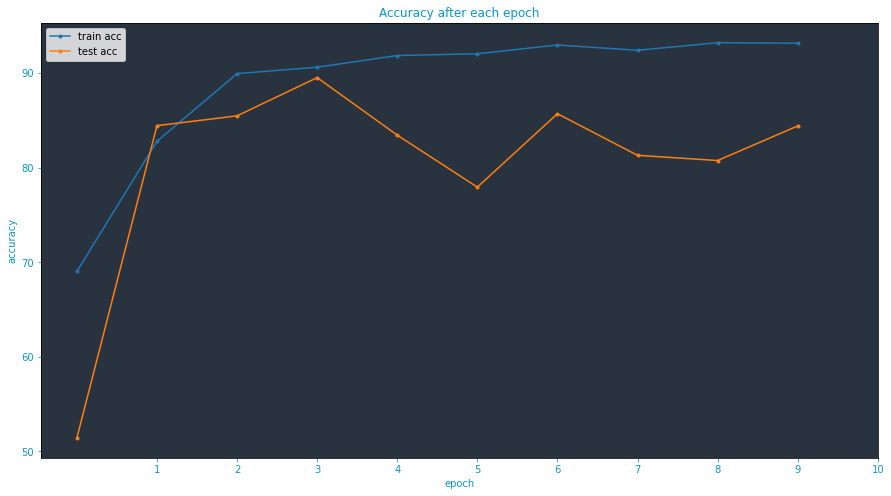

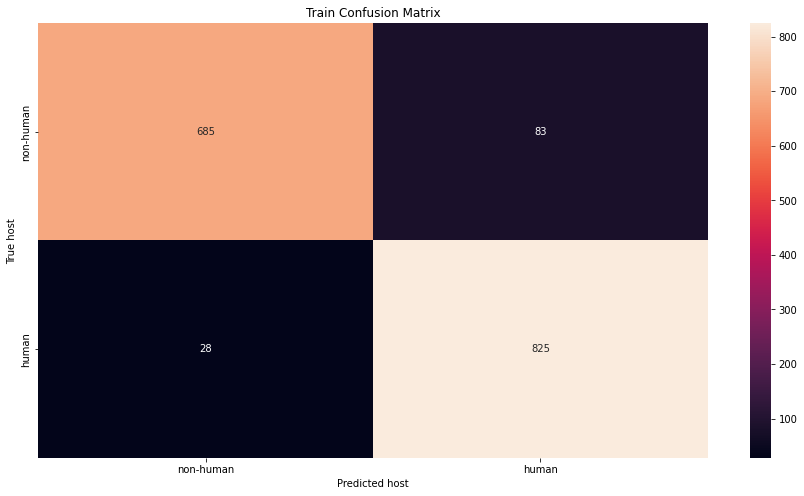

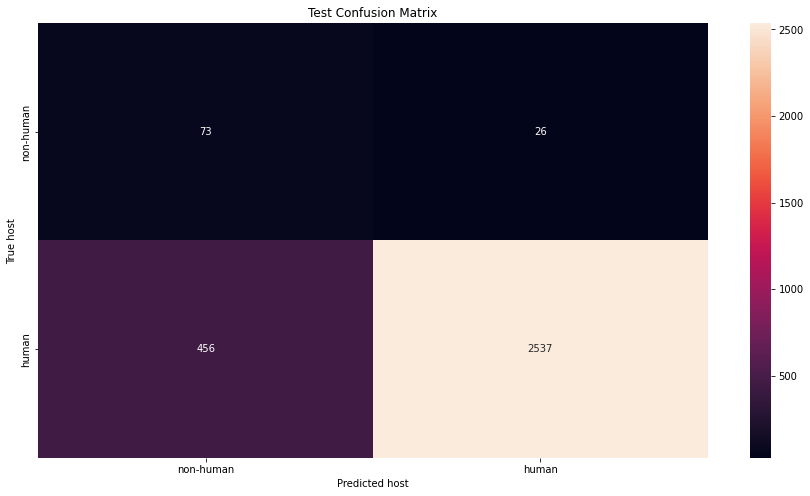

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

gru_model=GRUNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 60,
        "gru_hidden_dim": 60,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2
    }
)
gru_model=to_cuda(gru_model)

gru_dev_accuracies = train(gru_model, dengue_train, dengue_test, batch_size=2, epochs=10)
torch.save(gru_model, 'dengue_gru.pth')
del gru_model

  0%|          | 0/15 [00:00<?, ?it/s]

range(0, 15) [1.2525095700113025, 0.5910925216698878, 0.4058534556310303, 0.39052026527687983, 0.35072283378385755, 0.3179574735643325, 0.28950228559066826, 0.25942513794341027, 0.2604896172963535, 0.20009728726308887, 0.20679025328398418, 0.19994451632023683, 0.19074719005876326, 0.17945928334847913, 0.18221314003469266]


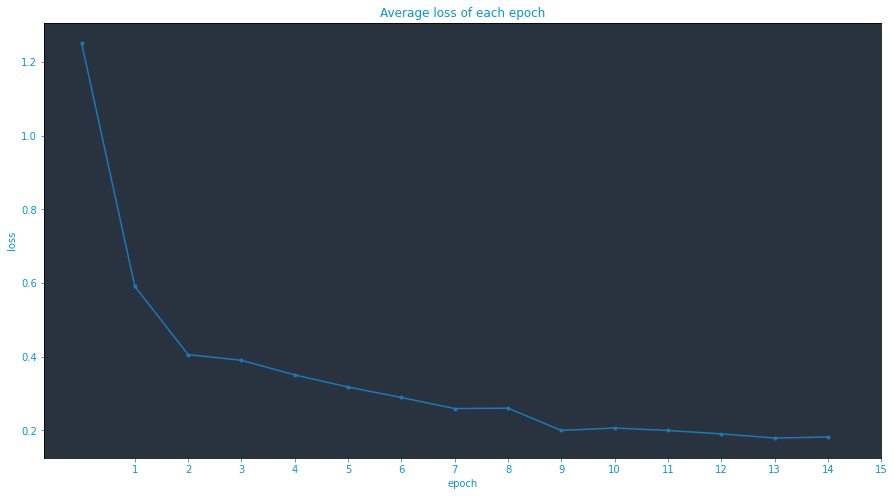

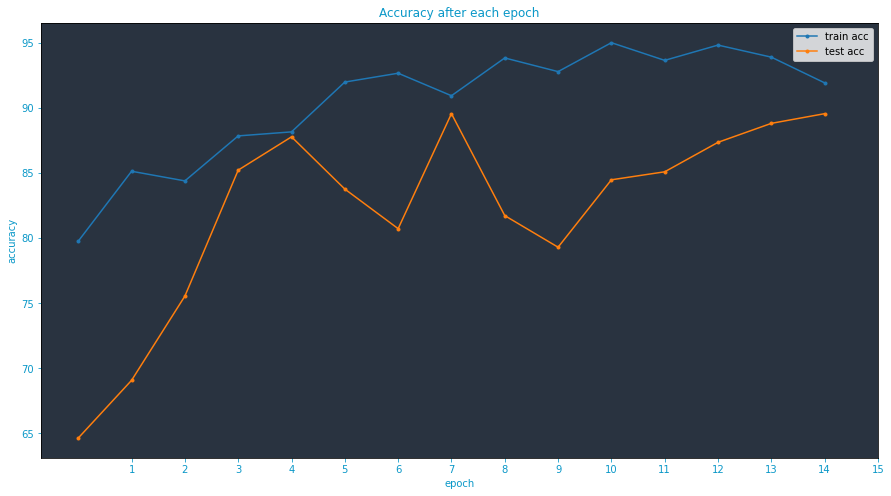

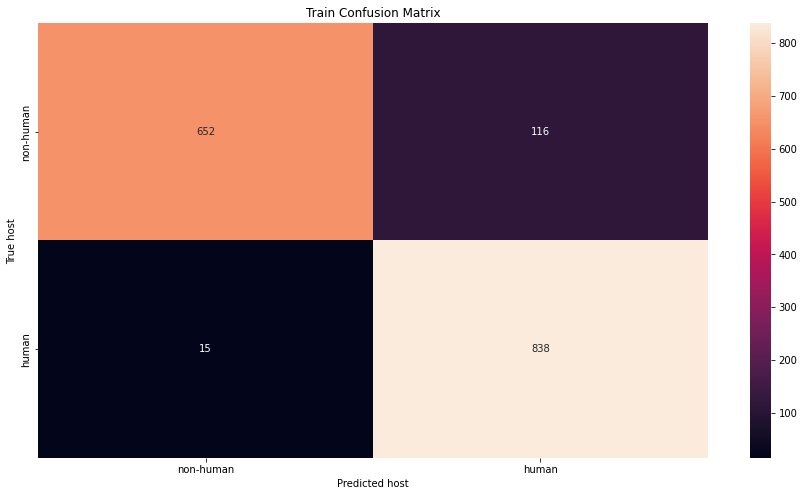

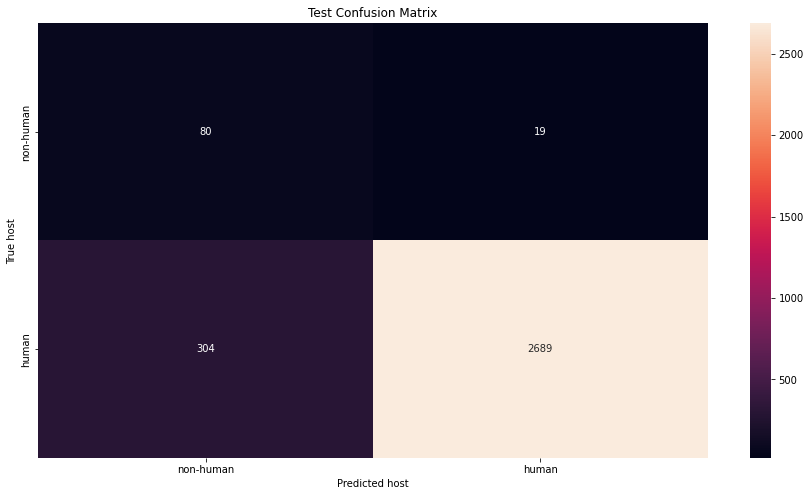

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.005
conv1d_model=Conv1dNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim":50,
        "feature_size":50,
        "window_sizes":[3,5,7,9],
        "number_of_tags": 2,
        "dropout": 0.2
    }
)
conv1d_model=to_cuda(conv1d_model)

conv1d_dev_accuracies = train(conv1d_model, dengue_train, dengue_test, batch_size=1, epochs=15)
torch.save(conv1d_model, 'dengue_conv1d.pth')
del conv1d_model

Legjobb ebola modellek

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.48270264231912824, 0.3078706379440662, 0.1750153888352517, 0.1312199185874788, 0.14074366904398322, 0.07293119326034497, 0.08388187739312807, 0.056009168096823686, 0.05351181185967736, 0.053170100603657275, 0.05303390010156709, 0.06577464412737989, 0.04977795236255231, 0.06460719352568557, 0.07484506187507128, 0.05284270045617429, 0.05165919034918725, 0.051043736468070464, 0.05050368398367104, 0.05080142411809825]


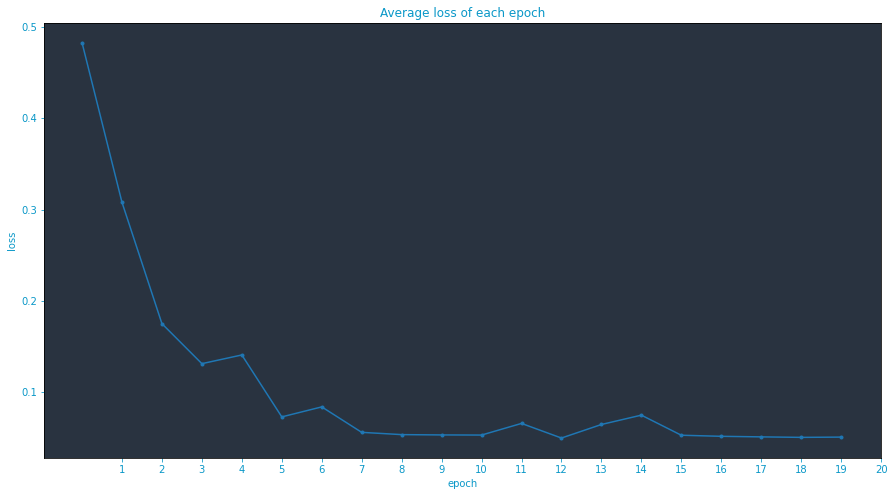

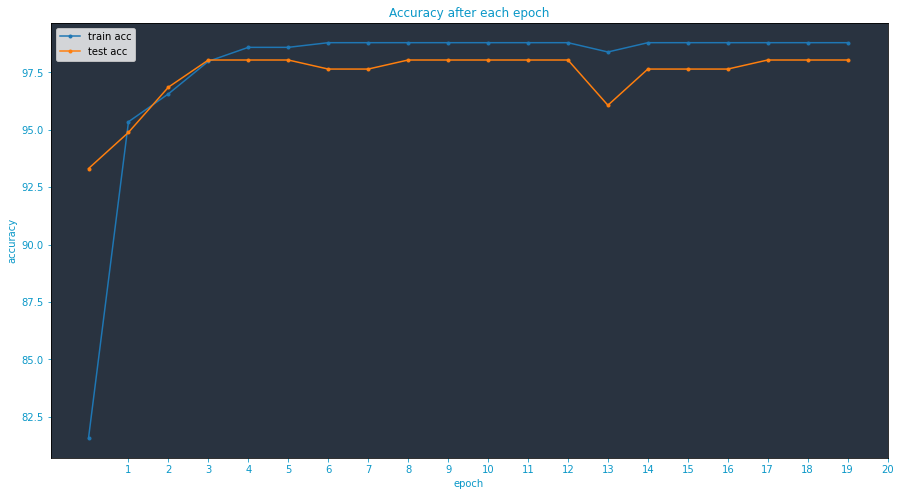

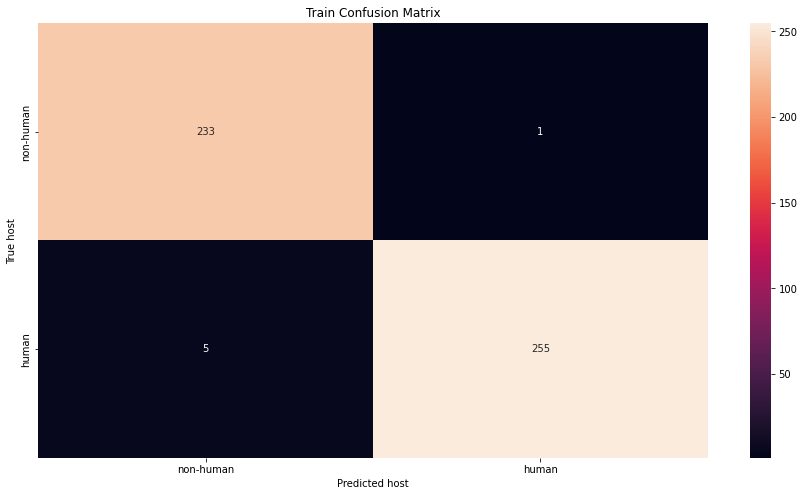

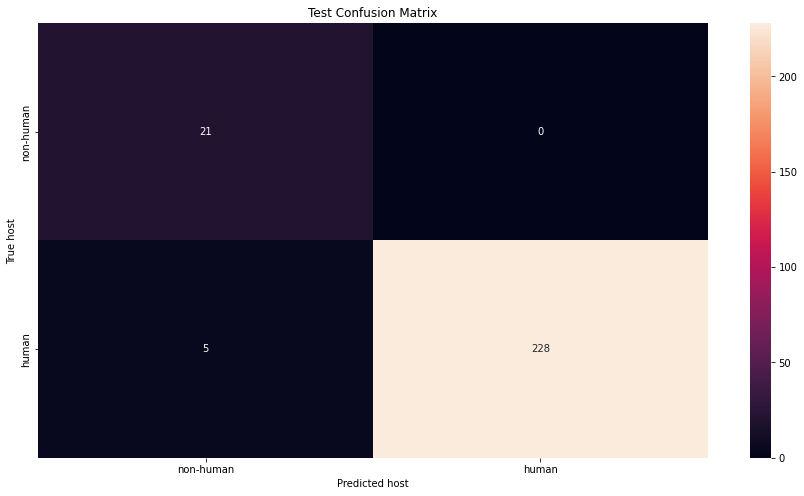

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": False
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, ebola_train, ebola_test, batch_size=2, epochs=20)
torch.save(lstm_model, 'ebola_lstm.pth')
del lstm_model

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.4302176756111279, 0.19515680491326656, 0.08520937854646109, 0.06700959599175446, 0.06579126151707985, 0.056706607395408136, 0.08792879982773207, 0.04888446320414969, 0.041465707234480946, 0.03370509292487076, 0.03493570550046923, 0.02937340011883287, 0.027771743276518192, 0.027294063035374846, 0.03302516385002465, 0.027084500422597375, 0.03394338639148222, 0.02687973759403808, 0.02453857258785452, 0.026148394143112697]


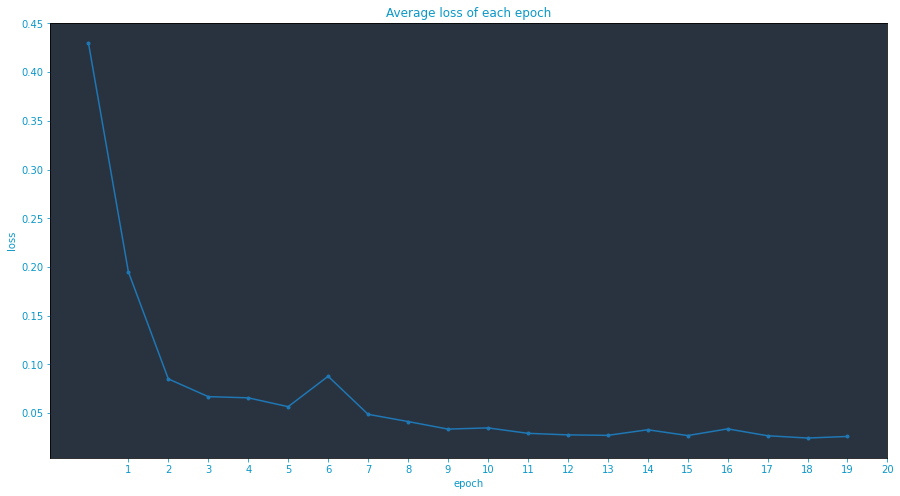

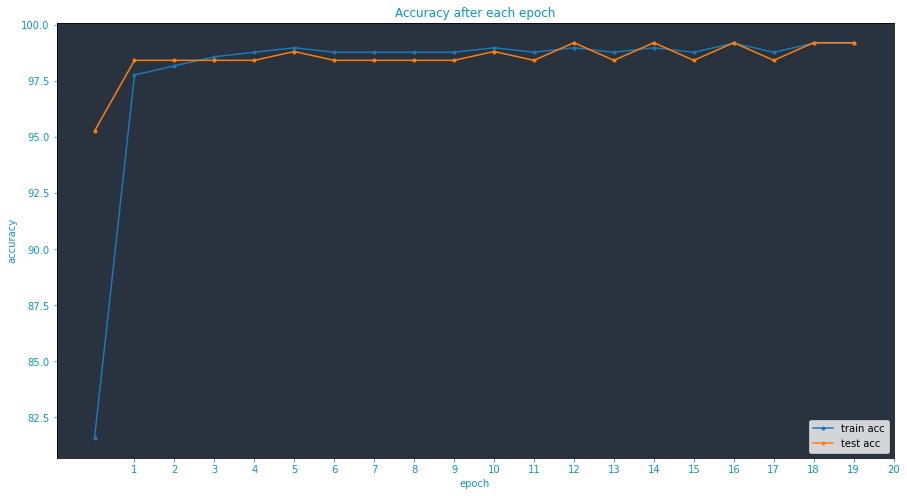

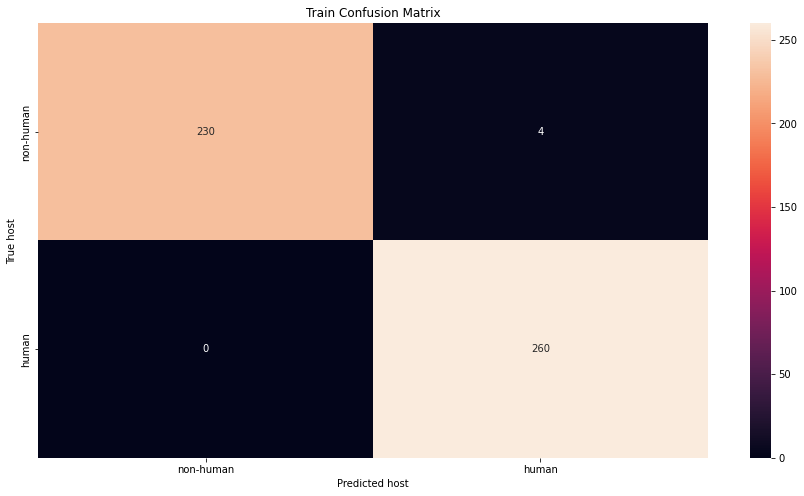

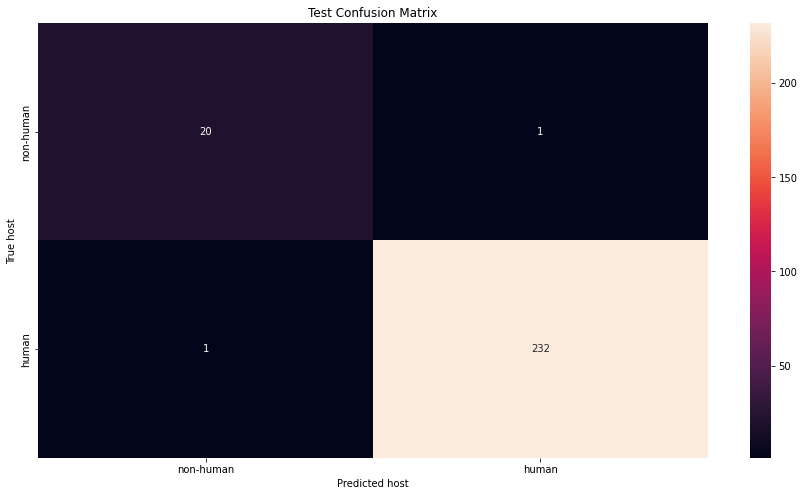

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 100,
        "lstm_hidden_dim": 75,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": True
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, ebola_train, ebola_test, batch_size=2, epochs=20)
torch.save(lstm_model, 'ebola_bilstm.pth')
del lstm_model

  0%|          | 0/10 [00:00<?, ?it/s]

range(0, 10) [0.40648215331197507, 0.13508487780868766, 0.08547314334338388, 0.0663489384283519, 0.05787865126383894, 0.053332281868875606, 0.05020737688036858, 0.05235629963774804, 0.05892138997175795, 0.04818880055136253]


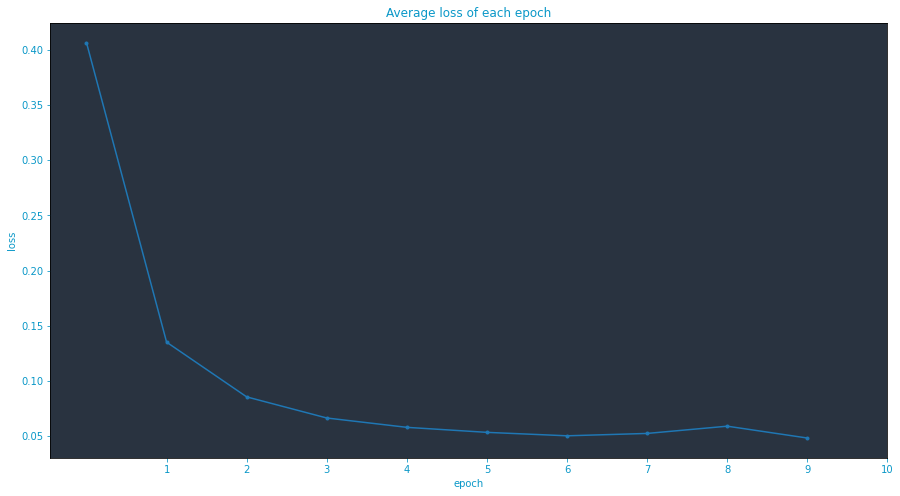

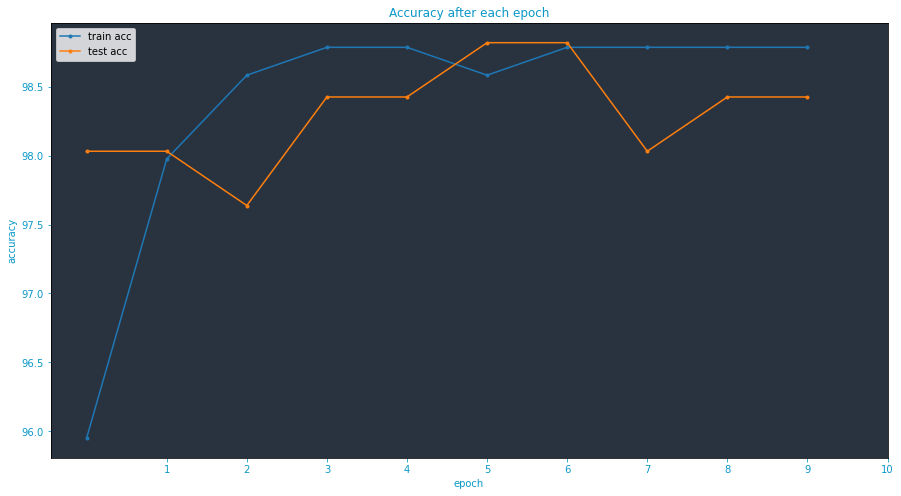

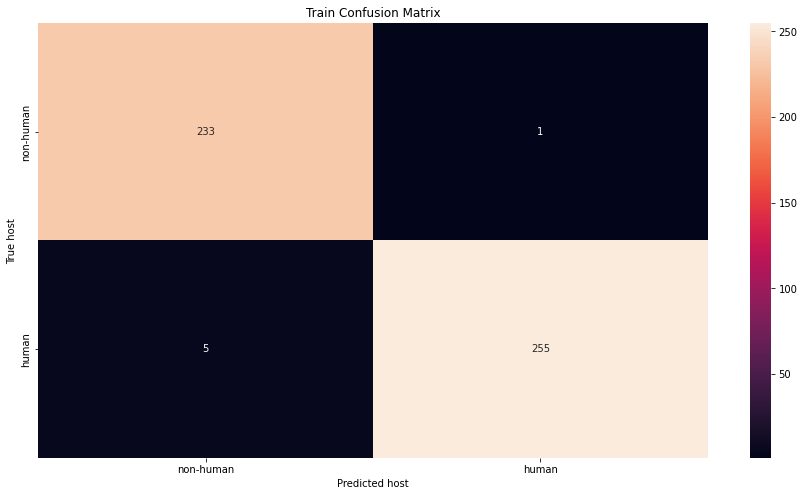

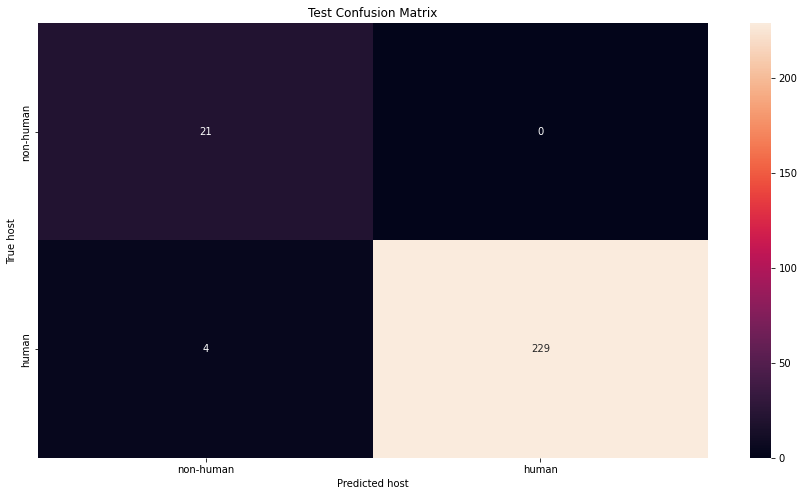

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

gru_model=GRUNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 60,
        "gru_hidden_dim": 60,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2
    }
)
gru_model=to_cuda(gru_model)

gru_dev_accuracies = train(gru_model, ebola_train, ebola_test, batch_size=2, epochs=10)
torch.save(gru_model, 'ebola_gru.pth')
del gru_model

  0%|          | 0/25 [00:00<?, ?it/s]

range(0, 25) [1.7101450357586145, 0.2823066730052233, 0.038911065296269955, 0.05218187037389725, 0.05284856026410125, 0.023598060302902013, 0.015014565517776645, 0.019119524807319977, 0.014293261399143376, 0.012415658733516466, 0.01327141693327576, 0.01293614242458716, 0.011868402820255142, 0.007218635242315941, 0.007119494366997969, 0.0057922150896047245, 0.00717405908726505, 0.007919176267751026, 0.005160833906847984, 0.007759093068307266, 0.005750796024949522, 0.004856289763120003, 0.0036804422525165137, 0.006848380505107343, 0.006106662061574753]


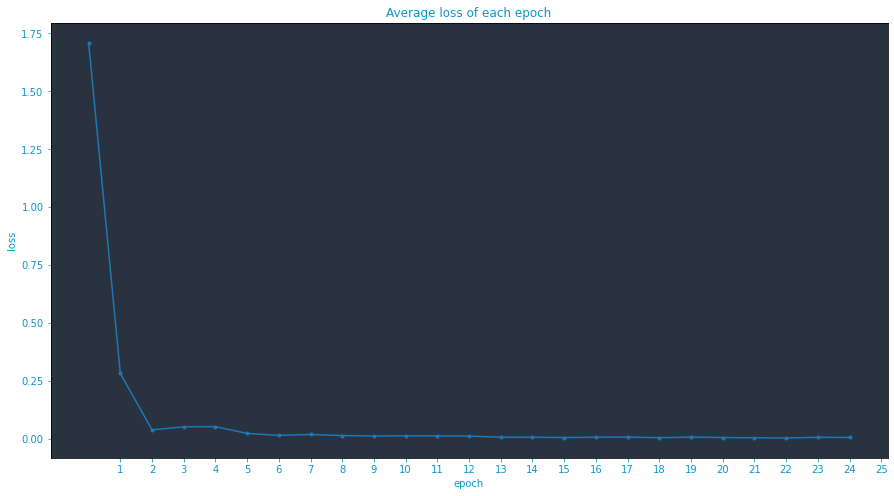

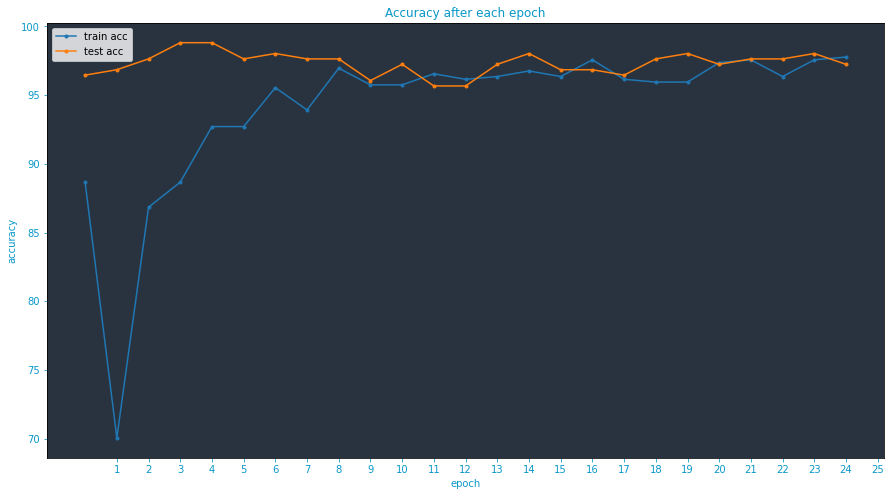

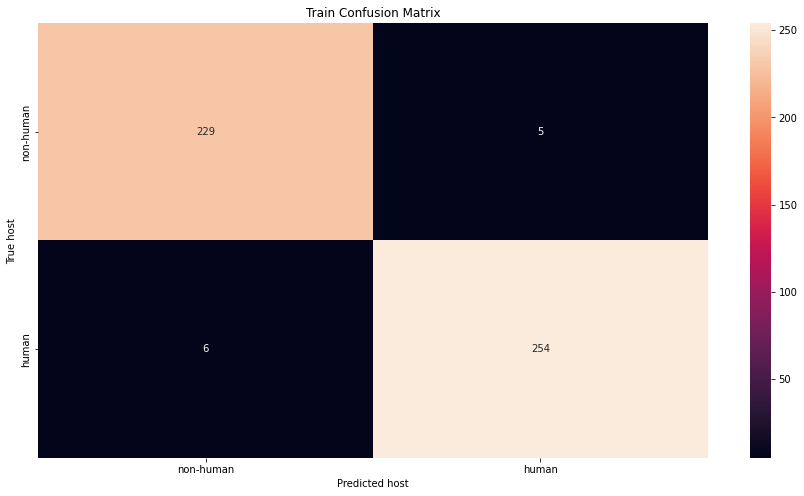

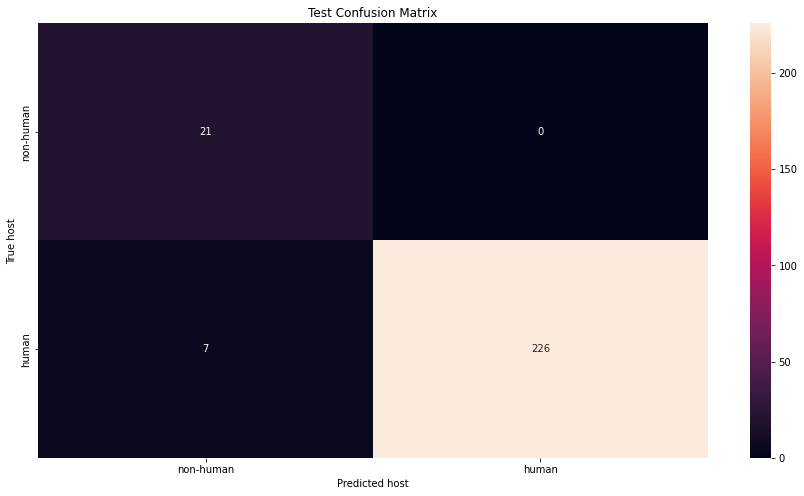

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001
conv1d_model=Conv1dNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim":100,
        "feature_size":100,
        "window_sizes":[3,5,7,9],
        "number_of_tags": 2,
        "dropout": 0.2
    }
)
conv1d_model=to_cuda(conv1d_model)

conv1d_dev_accuracies = train(conv1d_model, ebola_train, ebola_test, batch_size=100, epochs=25)
torch.save(conv1d_model, 'ebola_conv1d.pth')
del conv1d_model

Legjobb MERS modellek

  0%|          | 0/10 [00:00<?, ?it/s]

range(0, 10) [0.6911426291103763, 0.643043137969771, 0.6268283312857463, 0.5009118326749477, 0.42817690547224113, 0.34899000737679564, 0.30247189120160345, 0.2664274226737584, 0.26095206465045506, 0.2483627431153159]


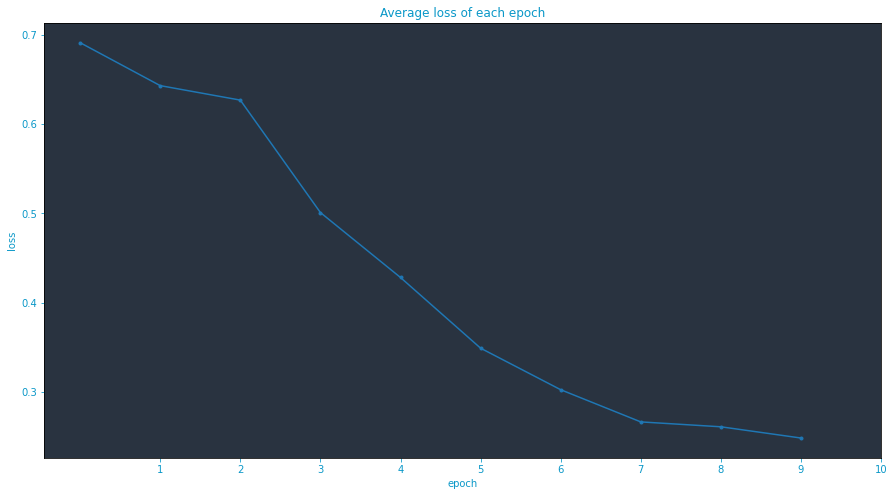

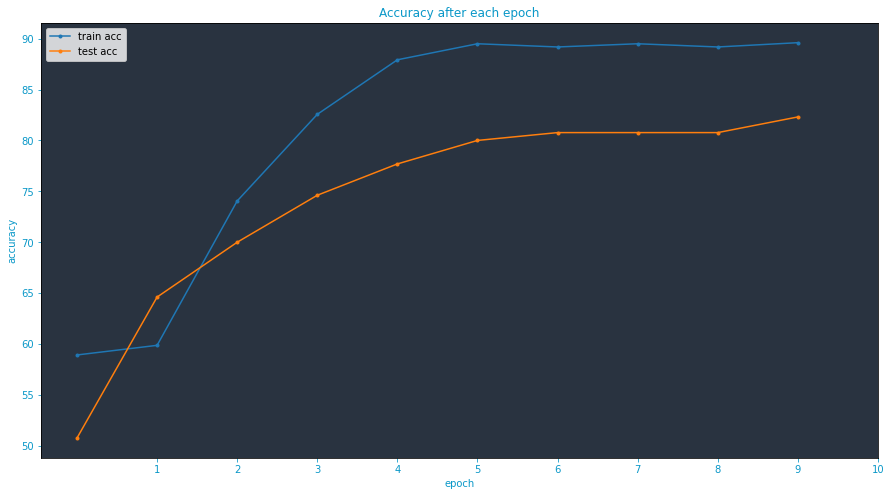

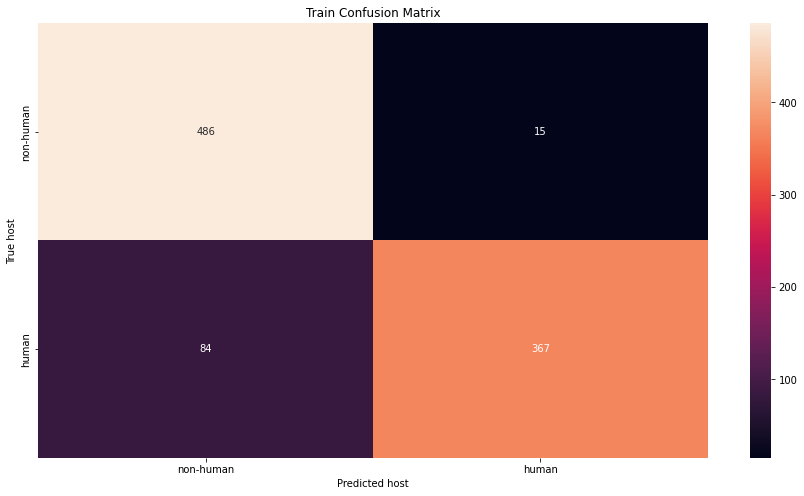

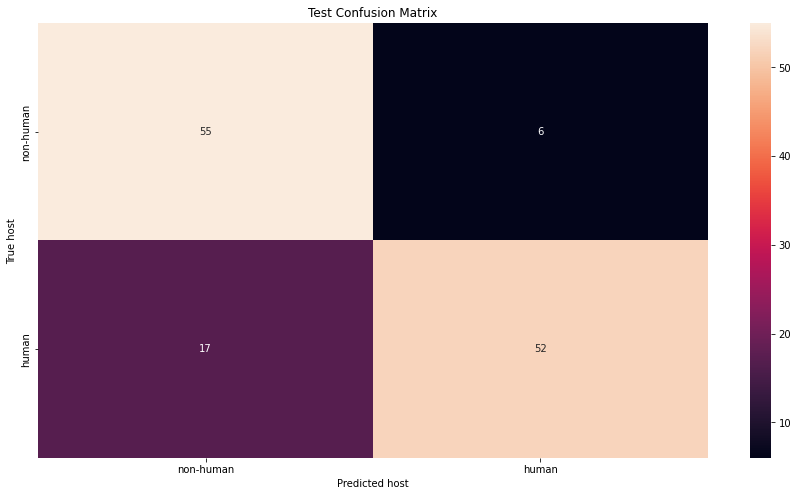

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.005

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": False
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, mers_train, mers_test, batch_size=5, epochs=10)
torch.save(lstm_model, 'mers_lstm.pth')
del lstm_model

  0%|          | 0/15 [00:00<?, ?it/s]

range(0, 15) [0.6901808705629479, 0.6430035555705974, 0.6288556174145943, 0.5034011422183501, 0.41233766141362216, 0.31662490974663127, 0.2882157807867408, 0.26039255776135395, 0.2622508873860717, 0.2461242916462309, 0.2364217625316525, 0.22801587712117202, 0.22468105416637674, 0.22076308928400823, 0.23370280374982516]


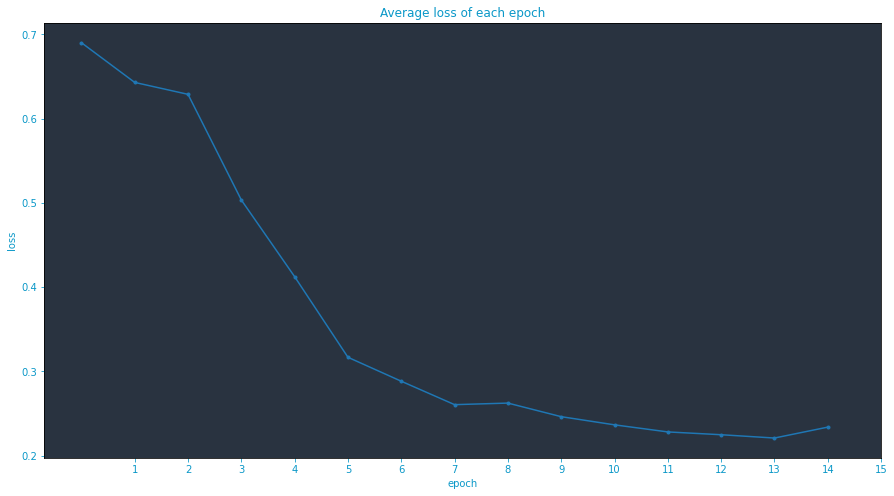

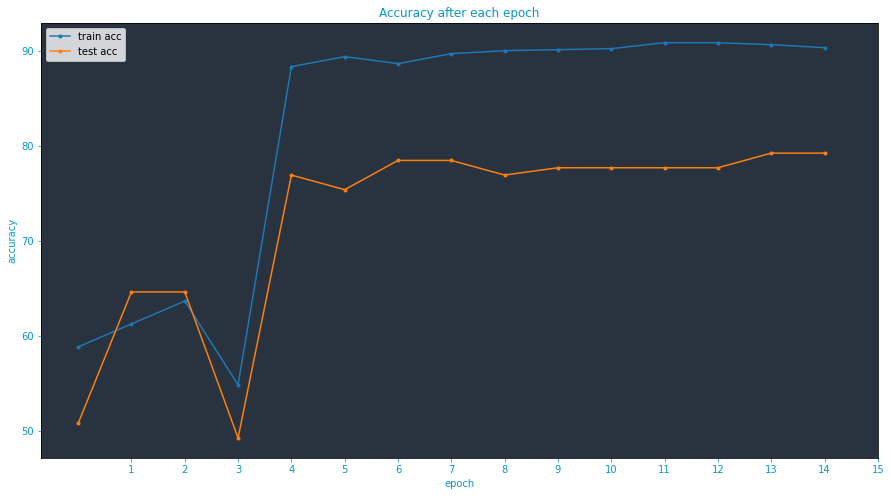

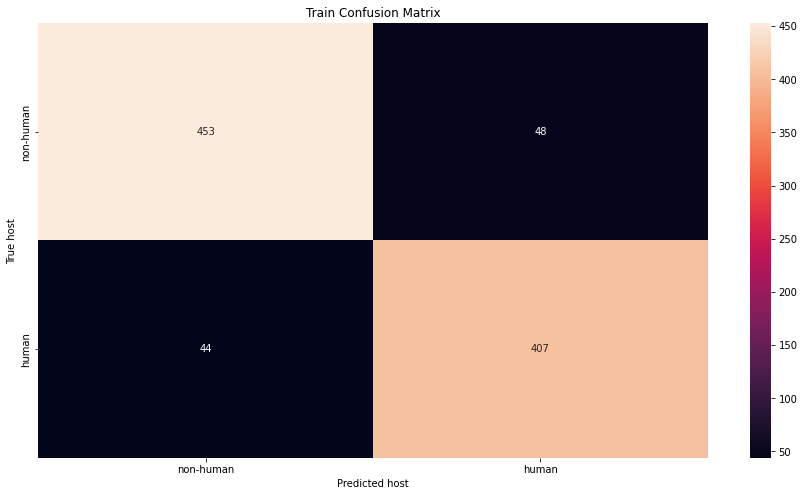

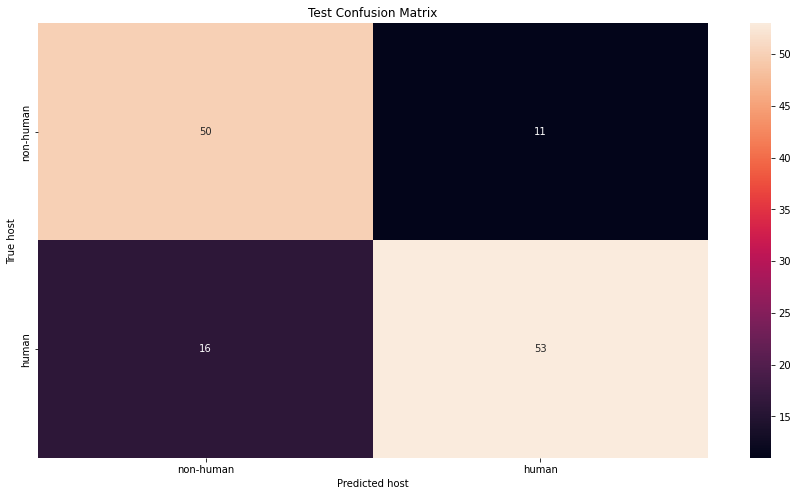

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.005

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": True
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, mers_train, mers_test, batch_size=5, epochs=15)
torch.save(lstm_model, 'mers_bilstm.pth')
del lstm_model

  0%|          | 0/10 [00:00<?, ?it/s]

range(0, 10) [0.6848333779117823, 0.6563384456472247, 0.6412489557765542, 0.5870152800026989, 0.43090804194280613, 0.3320170037389894, 0.2880864083396359, 0.2605199296202959, 0.2511984946898609, 0.24435997799682524]


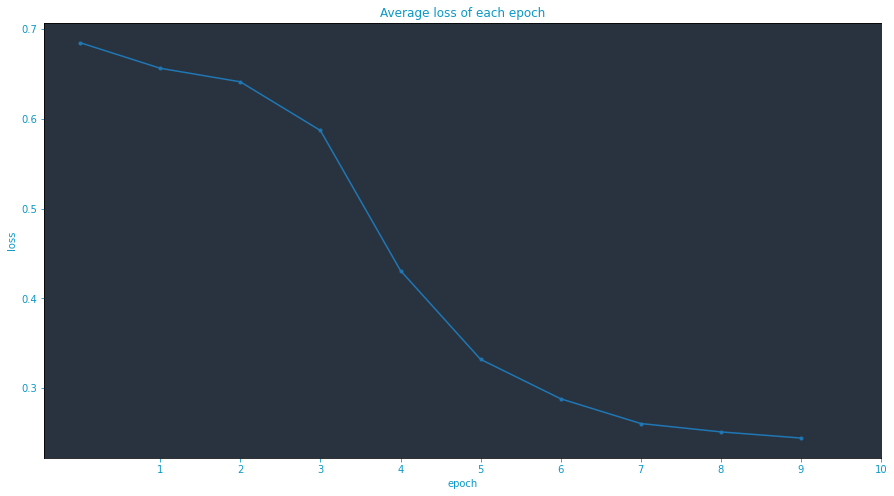

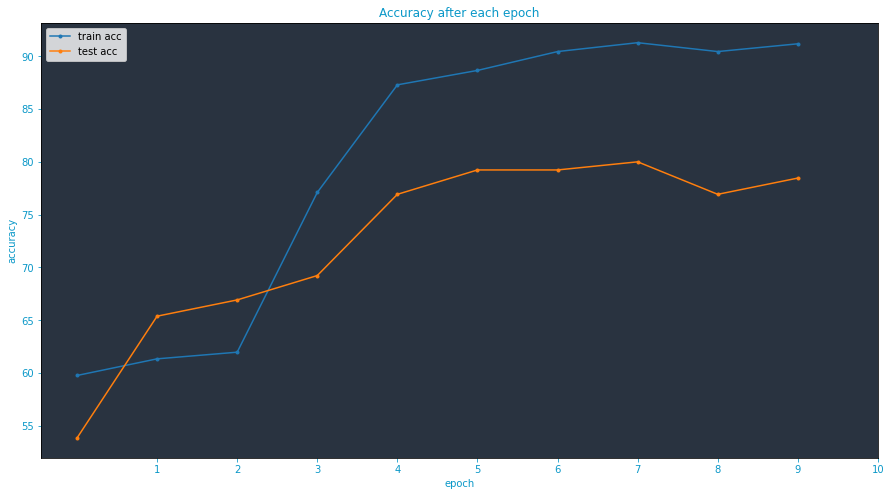

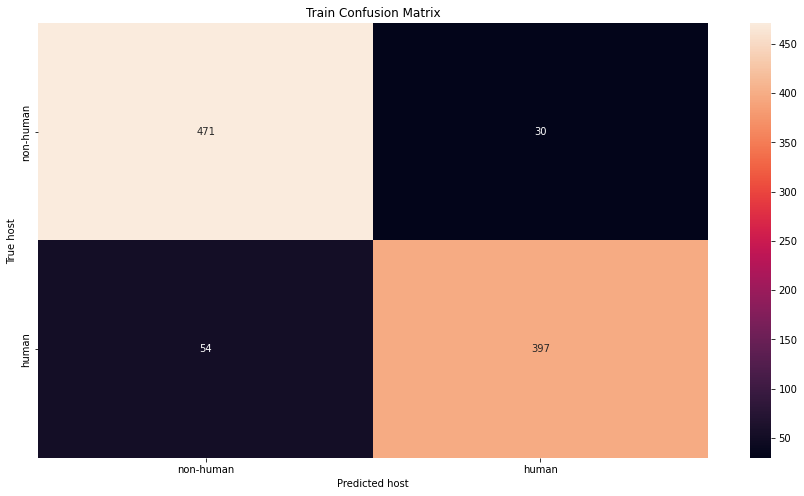

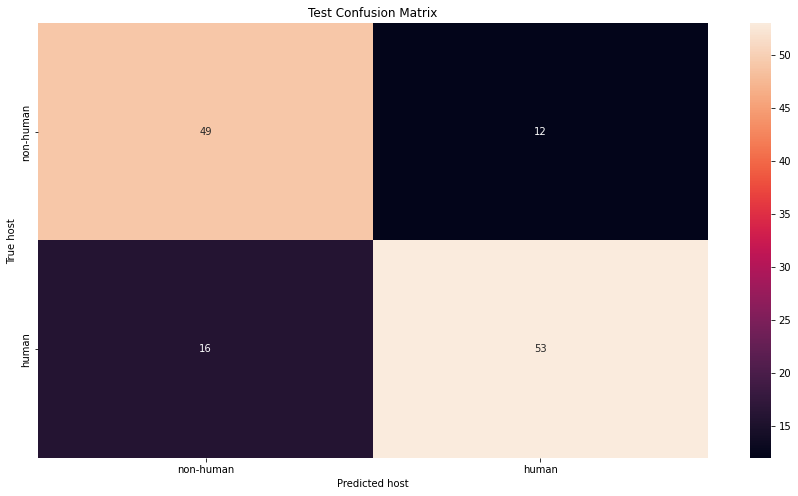

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

gru_model=GRUNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 60,
        "gru_hidden_dim": 60,
        "number_of_tags": 2,
        "num_layers": 3,
        "dropout": 0.2
    }
)
gru_model=to_cuda(gru_model)

gru_dev_accuracies = train(gru_model, mers_train, mers_test, batch_size=5, epochs=10)
torch.save(gru_model, 'mers_gru.pth')
del gru_model

  0%|          | 0/25 [00:00<?, ?it/s]

range(0, 25) [4.598656249046326, 0.8240566402673721, 0.7277557551860809, 0.7754686683416366, 0.7465906769037247, 0.6896611839532852, 0.7160036385059356, 0.7062848776578903, 0.7431482553482056, 0.7899778604507446, 0.6478973507881165, 0.5906864404678345, 0.5963057279586792, 0.5597448110580444, 0.5429630279541016, 0.554725170135498, 0.6200394421815872, 0.6101547658443451, 0.5614711880683899, 0.5747087657451629, 0.5354630291461945, 0.5839434742927552, 0.5931238293647766, 0.5172803282737732, 0.5402999639511108]


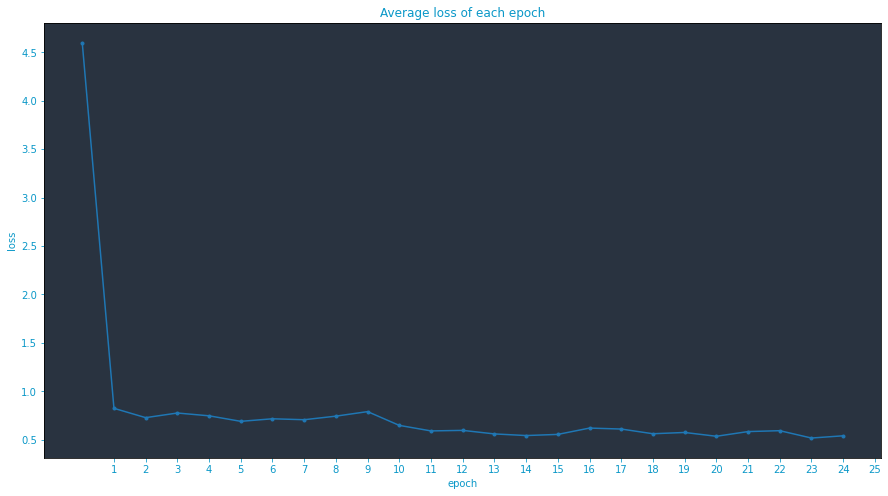

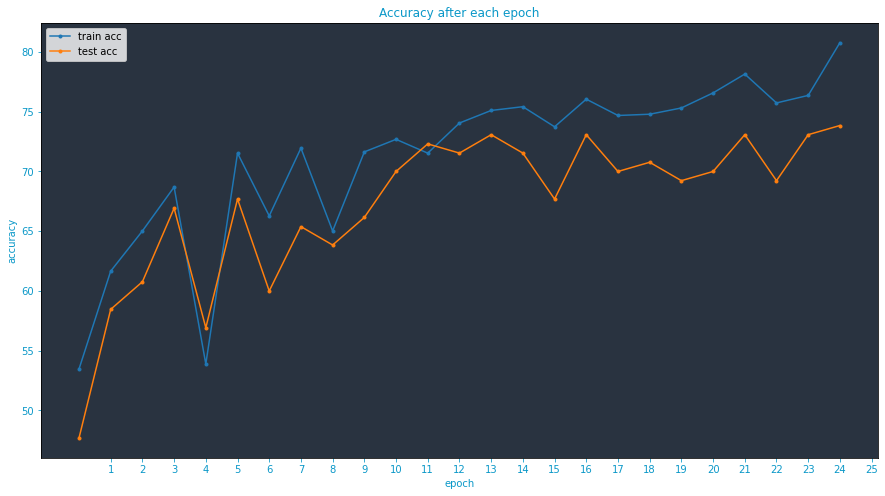

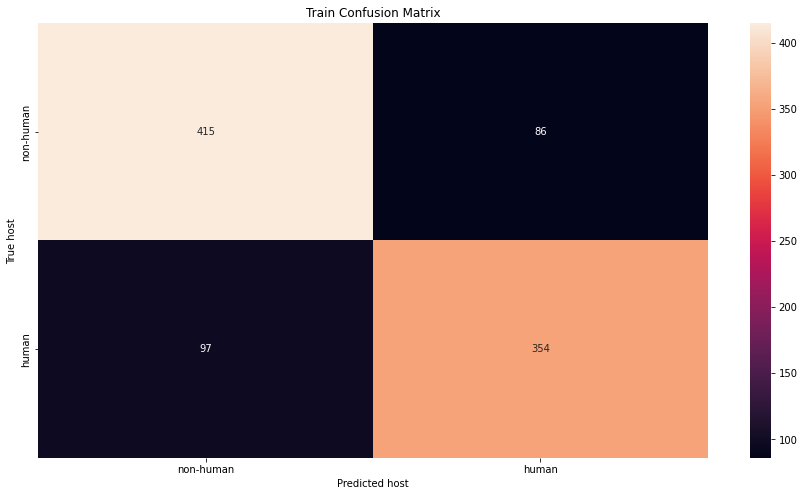

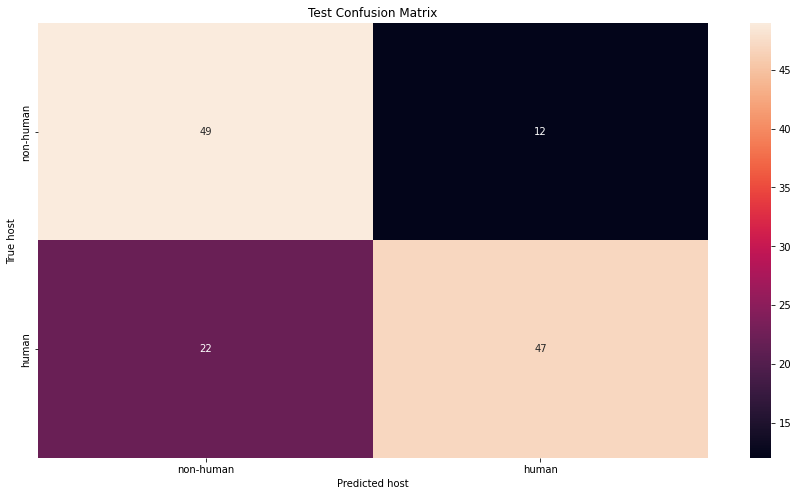

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.005
conv1d_model=Conv1dNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim":50,
        "feature_size":50,
        "window_sizes":[3,5,7,9],
        "number_of_tags": 2,
        "dropout": 0.2
    }
)
conv1d_model=to_cuda(conv1d_model)

conv1d_dev_accuracies = train(conv1d_model, mers_train, mers_test, batch_size=200, epochs=25)
torch.save(conv1d_model, 'mers_conv1d.pth')
del conv1d_model

Legjobb rota modellek

  0%|          | 0/30 [00:00<?, ?it/s]

range(0, 30) [0.7003521268199754, 0.6994958491933426, 0.6935346682599727, 0.6854240965323161, 0.6905166652778651, 0.6845062623087992, 0.6754353621462047, 0.7018456663061309, 0.6848197789400216, 0.6390707433823771, 0.47938069691193985, 0.34136329913799396, 0.31063631034437444, 0.2769153922446222, 0.24990248855128383, 0.2295681859972893, 0.2250811259368522, 0.19994333593937375, 0.18704277833286148, 0.18184872811672673, 0.16895783298817657, 0.1591855189419233, 0.16451434868594145, 0.14968056501758178, 0.1384371106056559, 0.142665872169071, 0.13964151060396193, 0.12652417099815888, 0.12203229921276137, 0.12747185862929428]


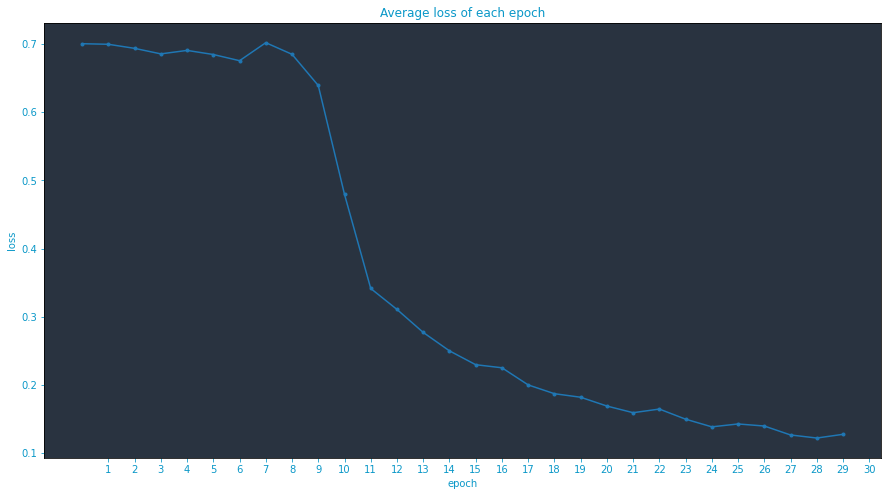

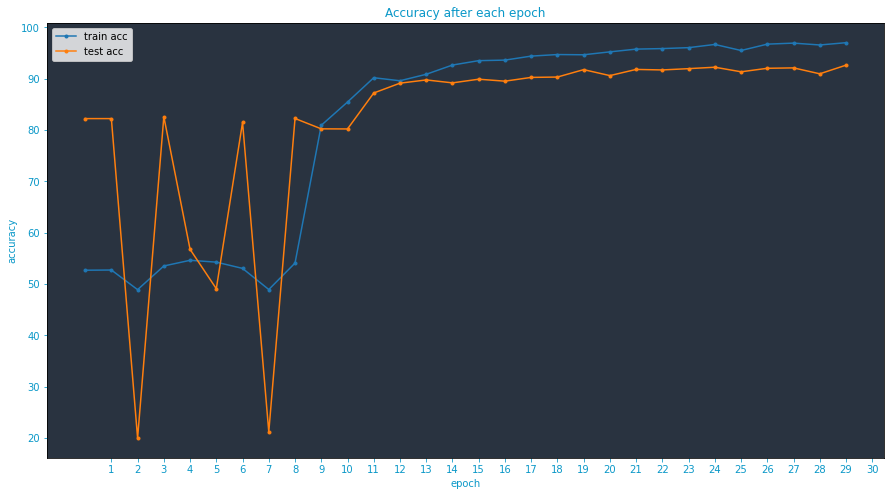

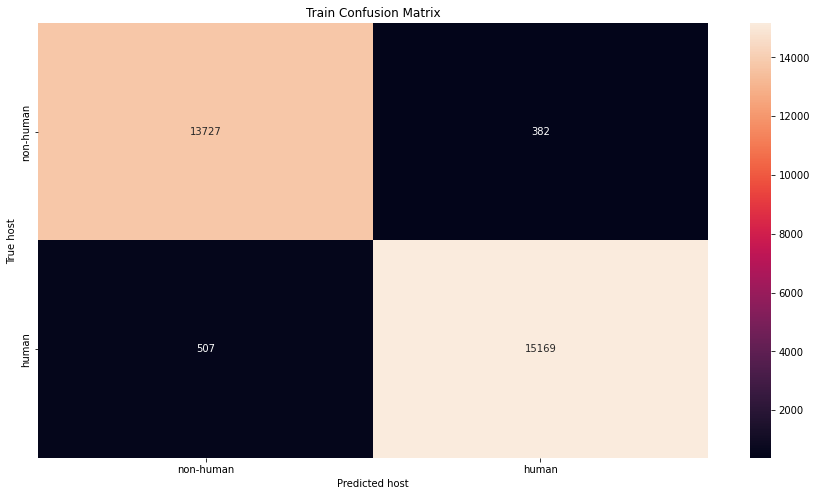

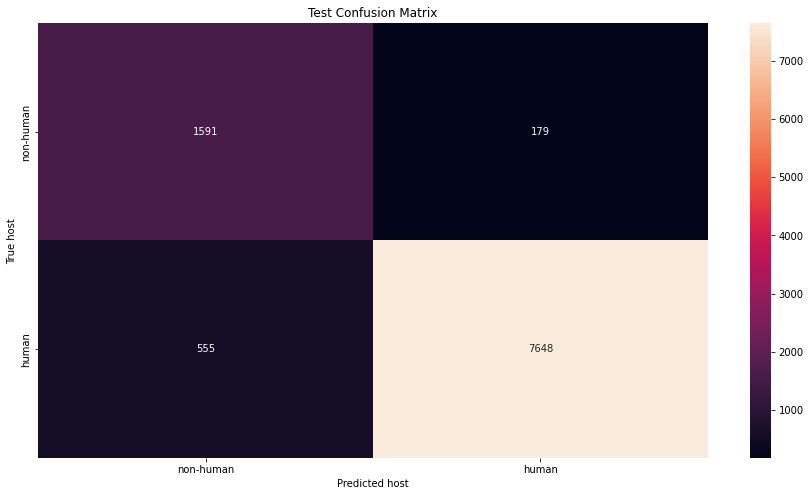

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": False
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, rota_train, rota_test, batch_size=100, epochs=30)
torch.save(lstm_model, 'rota_lstm.pth')
del lstm_model

  0%|          | 0/25 [00:00<?, ?it/s]

range(0, 25) [0.6991254038258687, 0.6988001459796956, 0.6939769775275416, 0.6909691147356225, 0.6836306080722169, 0.6794020955594594, 0.6761999512278793, 0.6602944499694261, 0.4928592307205568, 0.3403787550660188, 0.264862267563007, 0.22761464173961807, 0.1958856422879152, 0.18459828791752358, 0.16323358005525282, 0.14446756167449806, 0.14412258947330633, 0.13083731778116034, 0.11698121185908282, 0.1134166699590399, 0.11260756113310189, 0.10559321832749367, 0.09826708627214668, 0.09061568346649608, 0.08968680391038124]


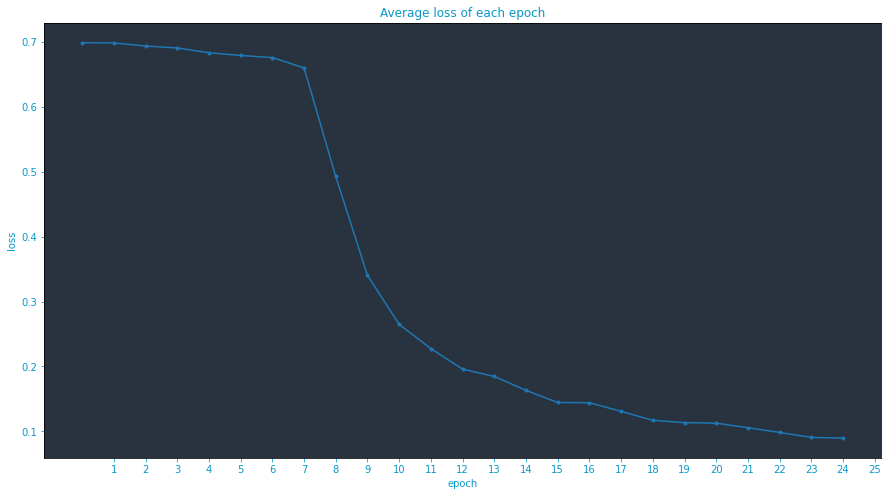

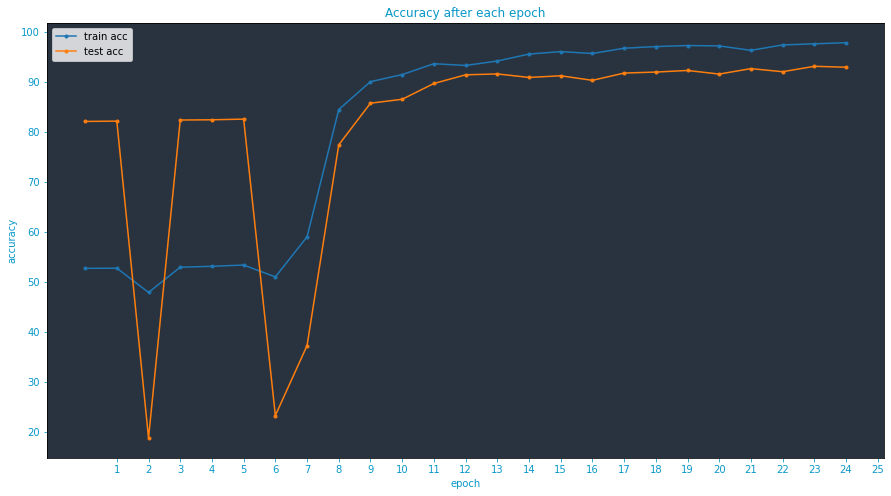

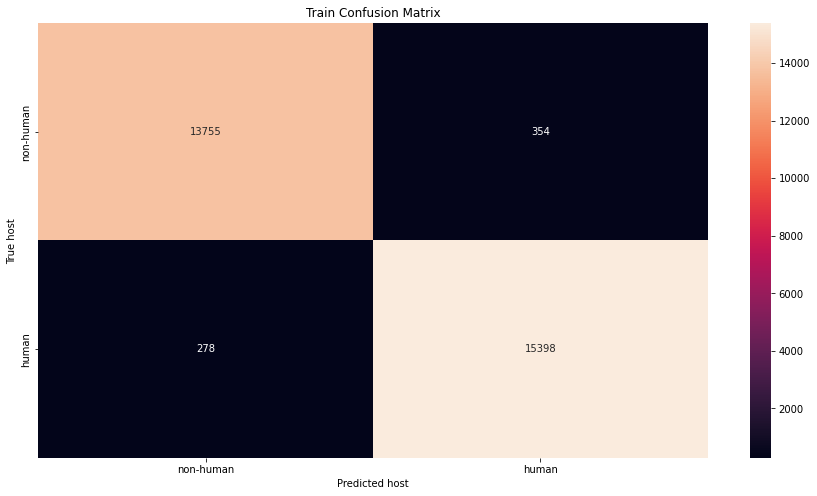

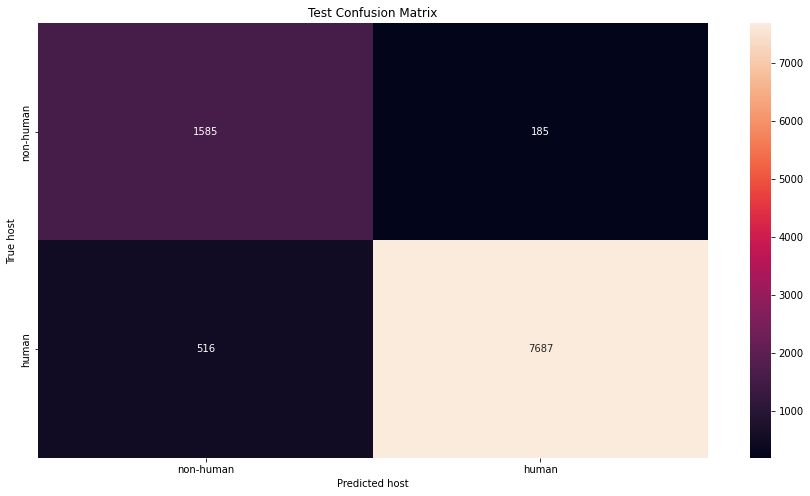

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": True
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, rota_train, rota_test, batch_size=100, epochs=25)
torch.save(lstm_model, 'rota_bilstm.pth')
del lstm_model

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.7081404261341031, 0.687946134365645, 0.48097423824087887, 0.3154893854770484, 0.23798460384593315, 0.19554153323523552, 0.16476847027622213, 0.13878794132588093, 0.12197252056067621, 0.10450203479861453, 0.09461050922513609, 0.08099155925564318, 0.06853490086247357, 0.06619640138944073, 0.061745630191239034, 0.0515076084587498, 0.05379856994606855, 0.04467395826667897, 0.040516085726609016, 0.03823225369251915]


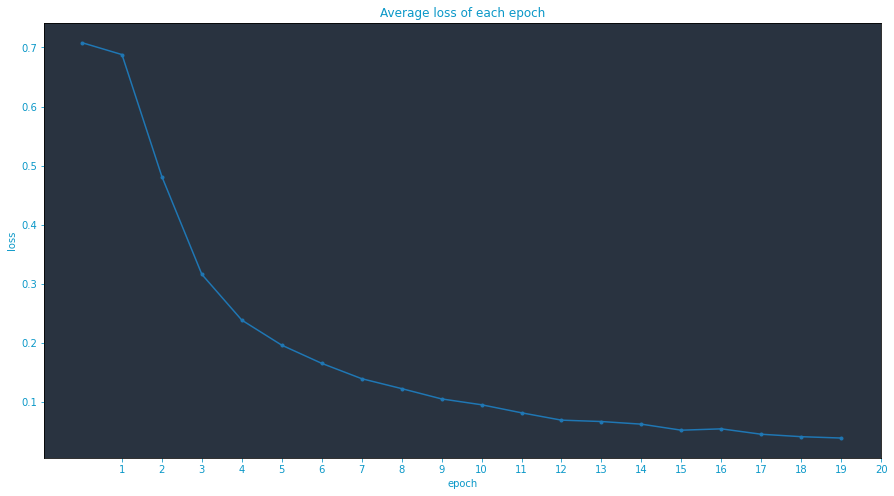

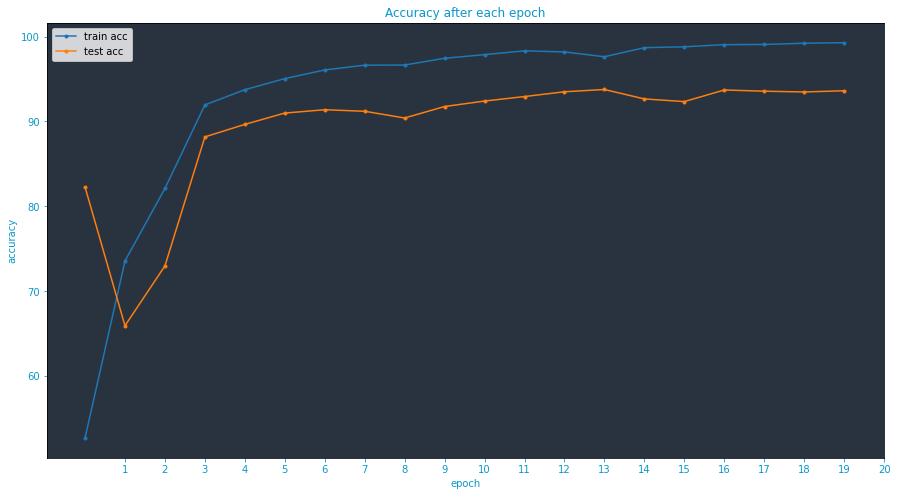

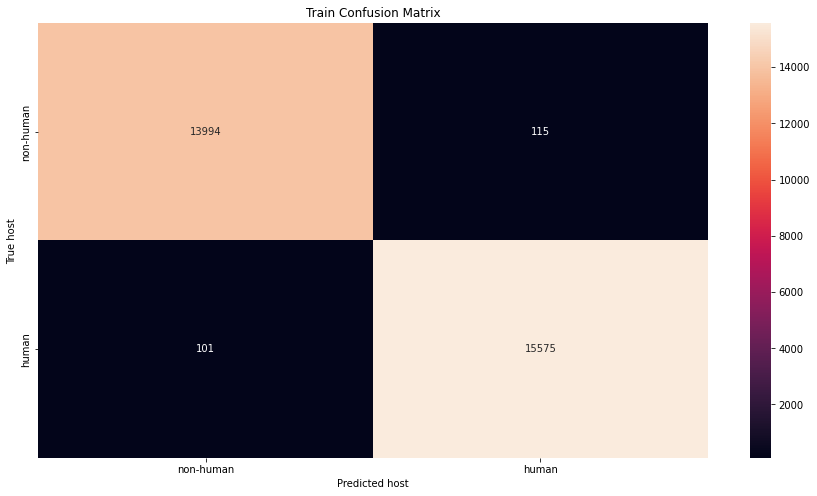

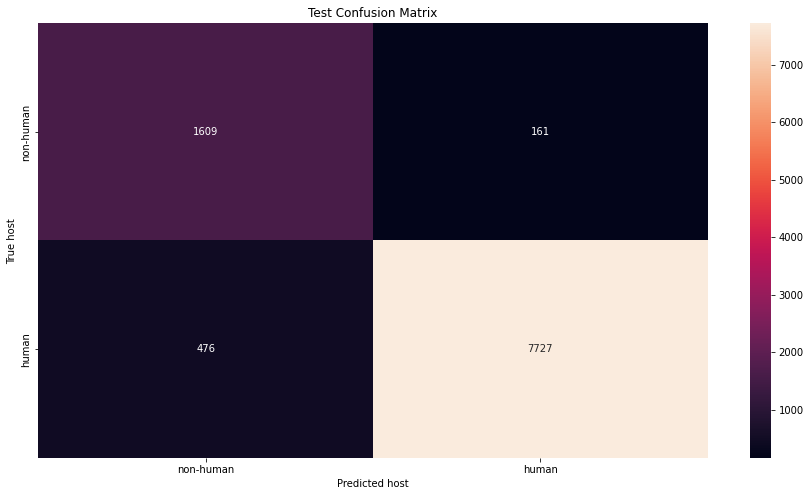

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

gru_model=GRUNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 60,
        "gru_hidden_dim": 60,
        "number_of_tags": 2,
        "num_layers": 3,
        "dropout": 0.2
    }
)
gru_model=to_cuda(gru_model)

gru_dev_accuracies = train(gru_model, rota_train, rota_test, batch_size=100, epochs=20)
torch.save(gru_model, 'rota_gru.pth')
del gru_model

  0%|          | 0/25 [00:00<?, ?it/s]

range(0, 25) [1.0250695467378192, 0.6601358875632286, 0.4542294356146915, 0.36462157749689666, 0.34231770847417764, 0.32353285131288456, 0.21204919874943143, 0.16151445291486363, 0.10732228836457201, 0.09714060486099002, 0.06151109562886741, 0.03753708018811932, 0.026593441596010937, 0.03664595899176034, 0.02173821987965513, 0.014529574295035532, 0.01591396156773471, 0.015053094284716, 0.00893735238909565, 0.007195535700708852, 0.009790673084328913, 0.005565286340737315, 0.005625274420763529, 0.013622885337294761, 0.0055795702783448696]


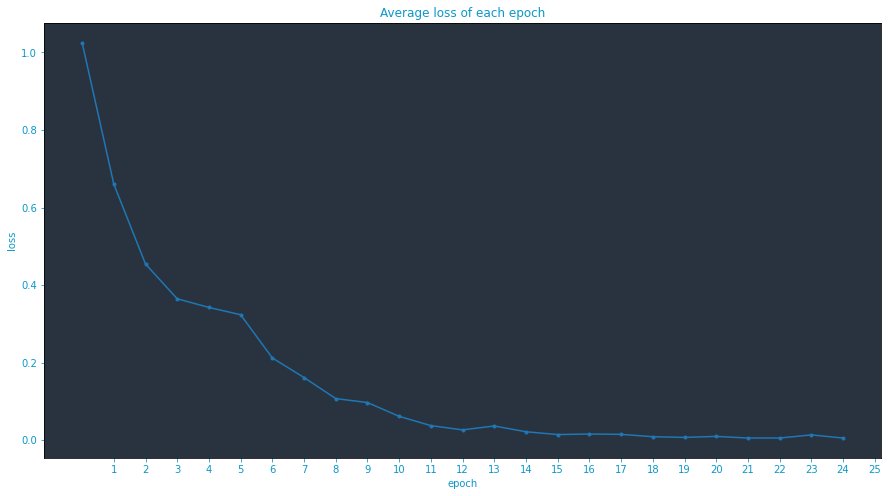

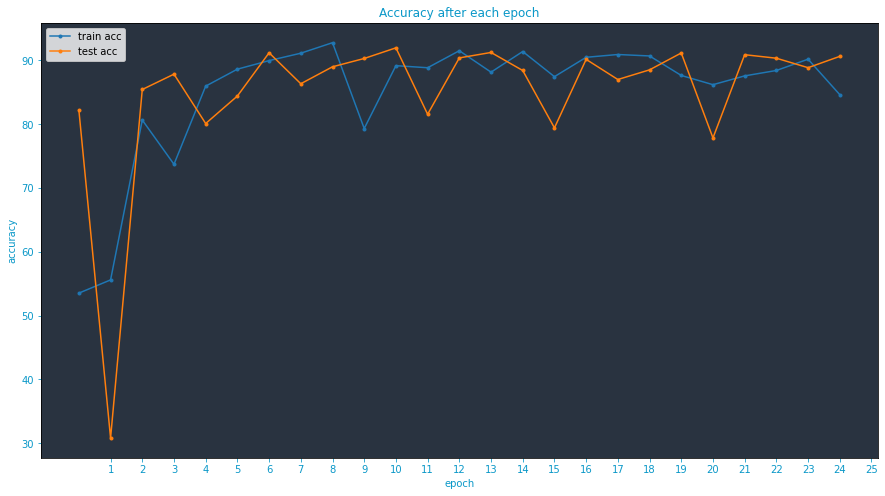

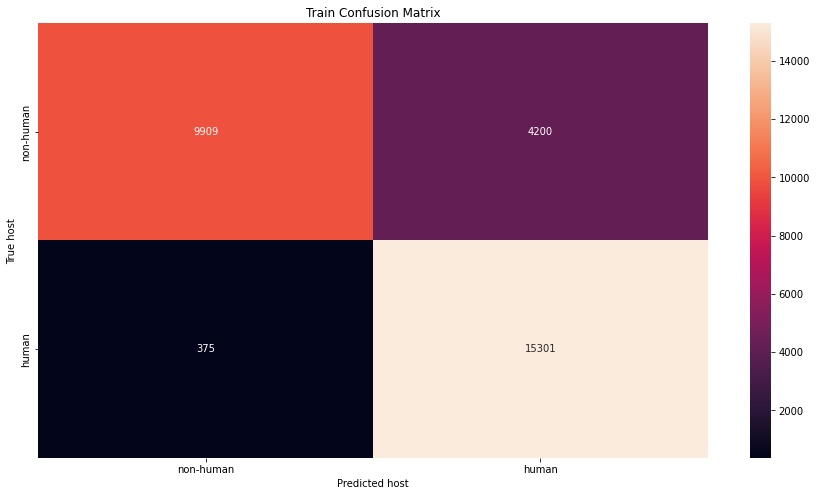

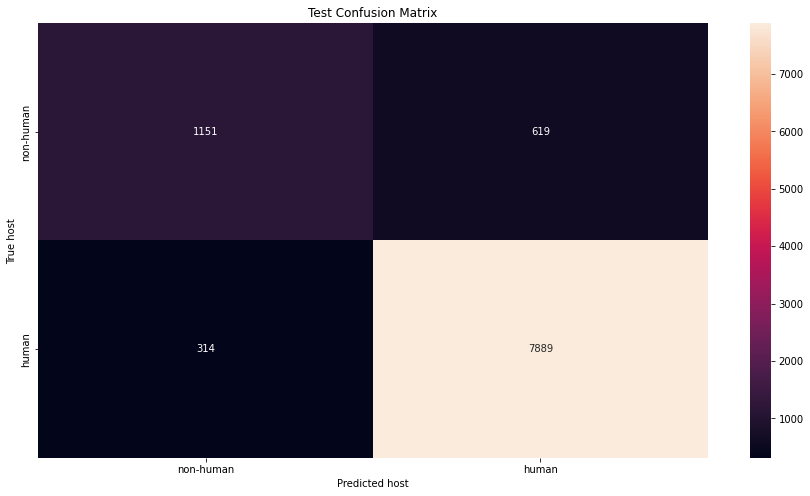

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001
conv1d_model=Conv1dNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim":100,
        "feature_size":100,
        "window_sizes":[3,5,7,9],
        "number_of_tags": 2,
        "dropout": 0.2
    }
)
conv1d_model=to_cuda(conv1d_model)

conv1d_dev_accuracies = train(conv1d_model, rota_train, rota_test, batch_size=200, epochs=25)
torch.save(conv1d_model, 'rota_conv1d.pth')
del conv1d_model

Legjobb west-Nile modellek

  0%|          | 0/25 [00:00<?, ?it/s]

range(0, 25) [0.7049600467330119, 0.6861395540296055, 0.6839718948133656, 0.675853725583827, 0.6643175106556689, 0.6545918283403896, 0.6475399129214834, 0.63775279092007, 0.6308606474614534, 0.6213917473300559, 0.5782113605346836, 0.5301969840389783, 0.500592866515527, 0.47729303187034167, 0.38730080004353995, 0.28036629344474095, 0.2156209421695256, 0.1594455392313663, 0.13497942781503328, 0.1276940871297275, 0.10615638350556436, 0.11006654259275461, 0.09225462699408231, 0.08877887856978618, 0.09166085646109899]


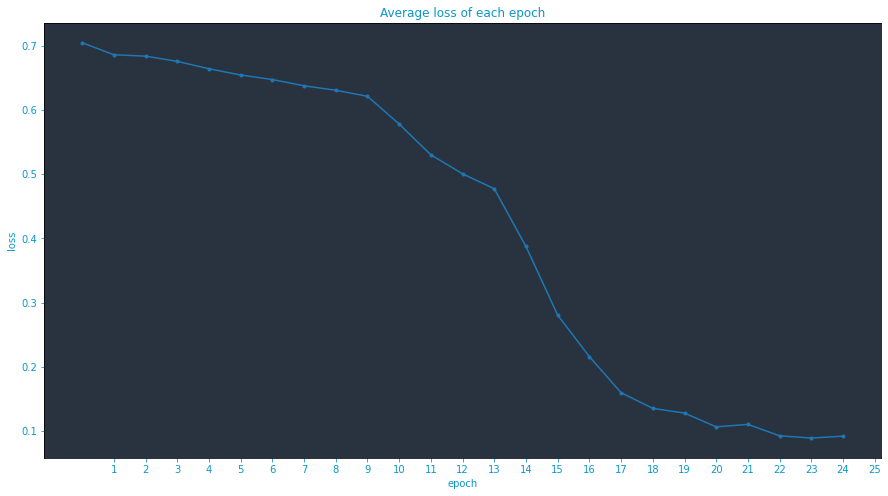

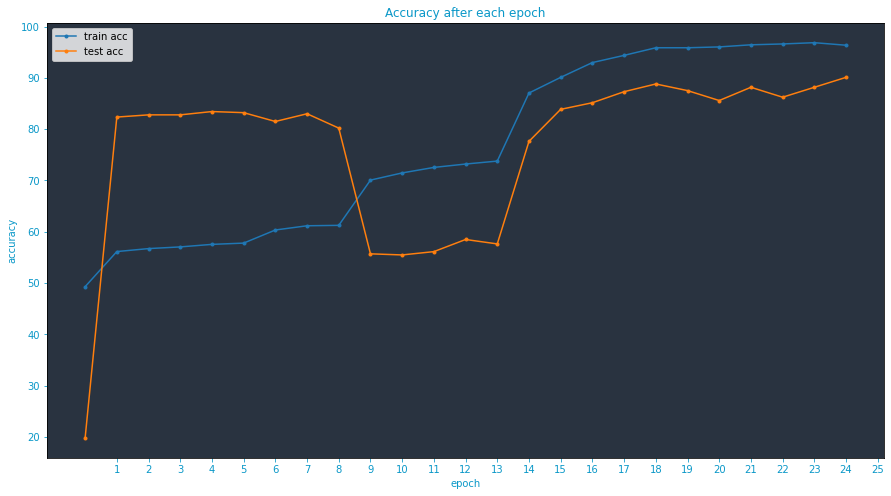

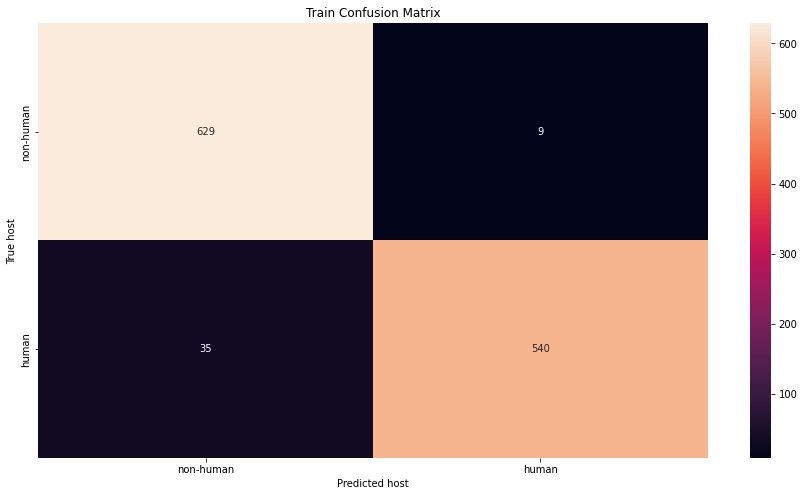

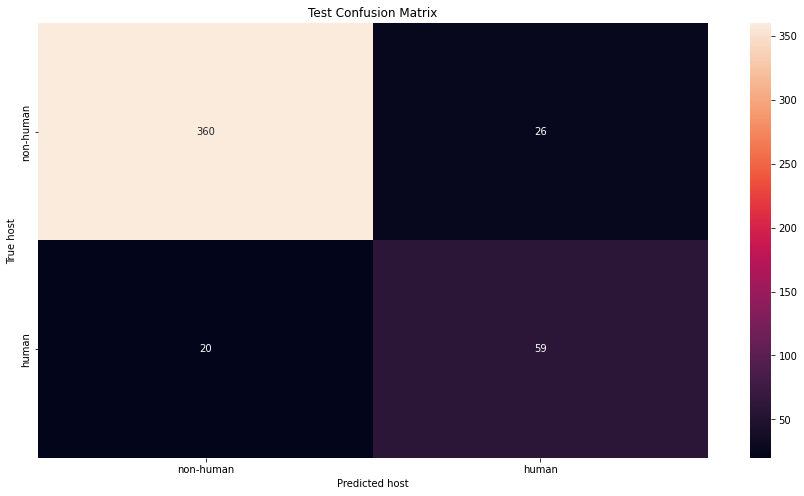

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": False
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, west_nile_train, west_nile_test, batch_size=10, epochs=25)
torch.save(lstm_model, 'west_nile_lstm.pth')
del lstm_model

  0%|          | 0/30 [00:00<?, ?it/s]

range(0, 30) [0.7042695601455501, 0.6866294350780424, 0.6843228464732405, 0.6760341376066208, 0.666488135325127, 0.6600621306016797, 0.6532666605026995, 0.6470859561298714, 0.6360049594621189, 0.6157761341968521, 0.5519119628140183, 0.5237699656701479, 0.5023141922276528, 0.4743674846946216, 0.4289784673296037, 0.34577990097344896, 0.273754408949467, 0.223137656929063, 0.2595753206577549, 0.1746554492942256, 0.15093735109663522, 0.13338432783932716, 0.12886003310196711, 0.16892682522779606, 0.13190629560744666, 0.126466113589246, 0.11635869193715273, 0.11251230506211153, 0.09981760281504544, 0.08564049573844207]


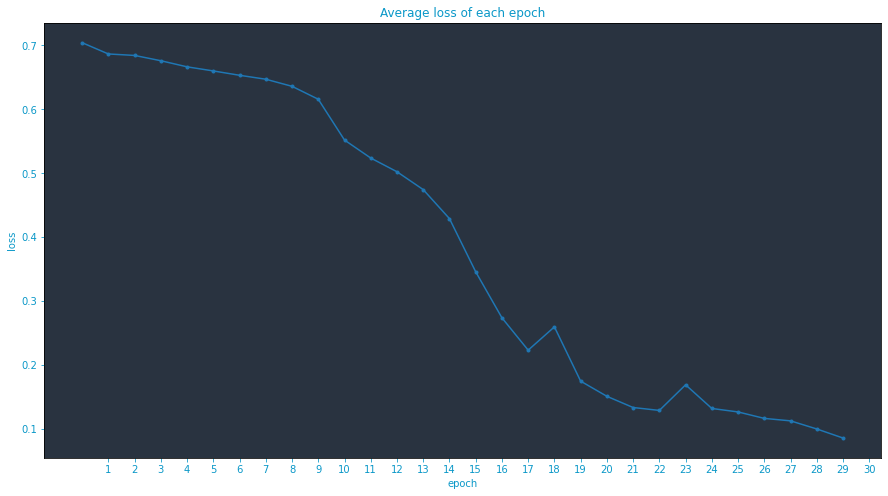

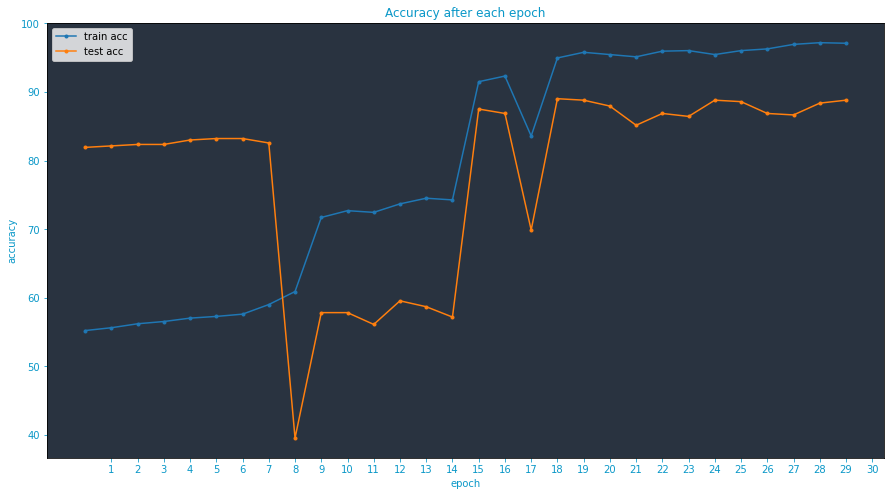

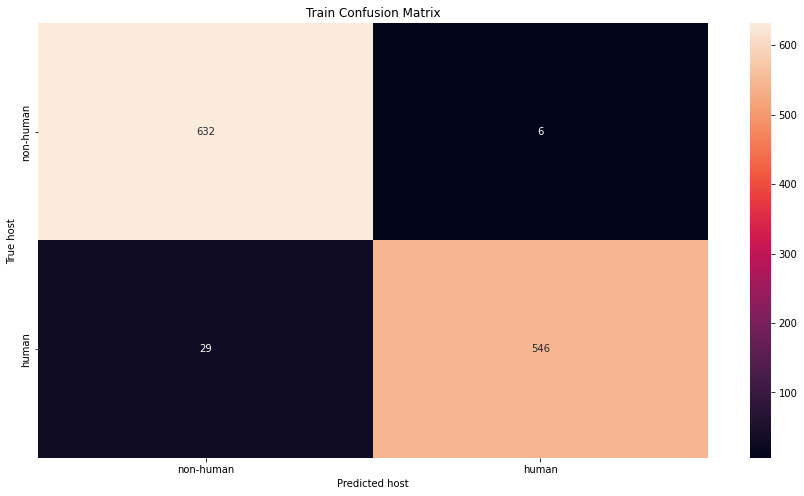

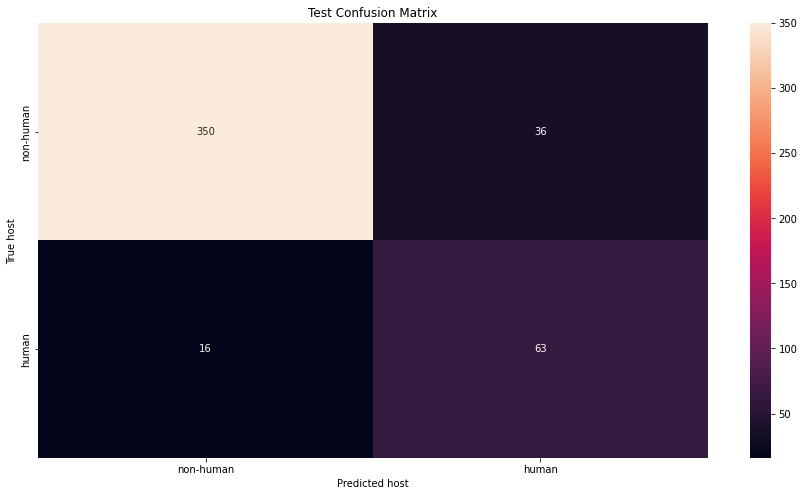

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": True
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, west_nile_train, west_nile_test, batch_size=10, epochs=30)
torch.save(lstm_model, 'west_nile_bilstm.pth')
del lstm_model

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.7211541704467086, 0.6910996268518635, 0.6796493078352975, 0.641493845914231, 0.39937318892019696, 0.23971758251551722, 0.18206653589779725, 0.14148954019622237, 0.11457911870427064, 0.10403610419741542, 0.09110520815201958, 0.08715320242660456, 0.07889914314537386, 0.06920641224991653, 0.06600746567376324, 0.05927344344243346, 0.07370228660731866, 0.062698228132995, 0.060307831913767165, 0.05762131232672875]


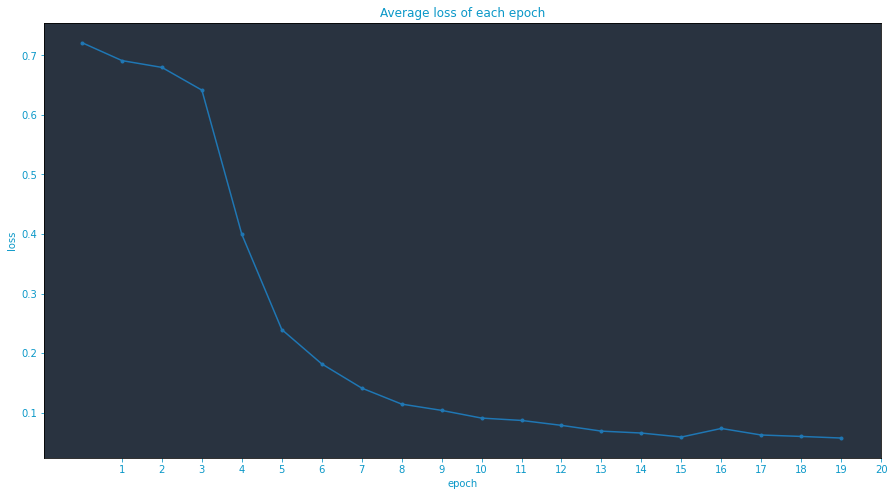

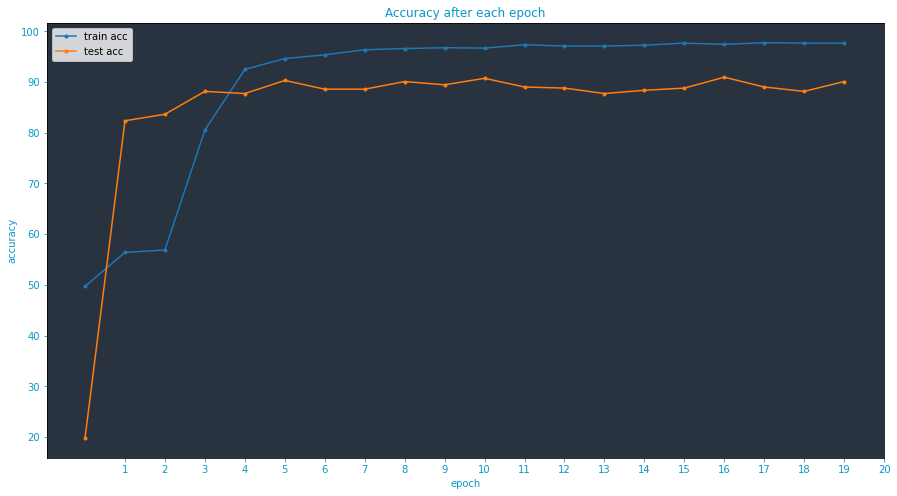

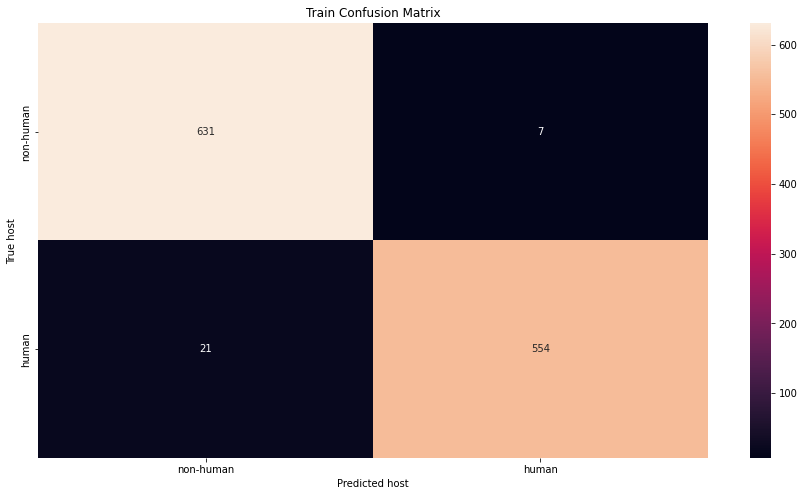

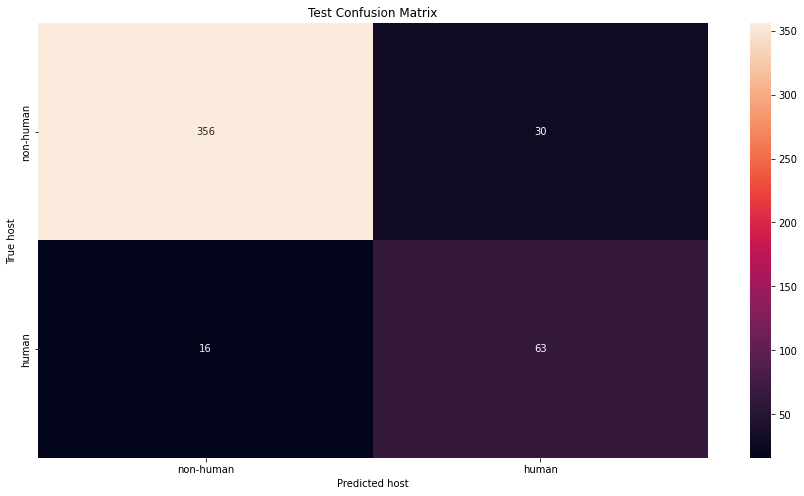

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

gru_model=GRUNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 70,
        "gru_hidden_dim": 70,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2
    }
)
gru_model=to_cuda(gru_model)

gru_dev_accuracies = train(gru_model, west_nile_train, west_nile_test, batch_size=10, epochs=20)
torch.save(gru_model, 'west_nile_gru.pth')
del gru_model

  0%|          | 0/25 [00:00<?, ?it/s]

range(0, 25) [1.0826900866540512, 0.3990323682674436, 0.32475301628896813, 0.3048962766741647, 0.3055992572185832, 0.24043003131242346, 0.33319291174114773, 0.24757372465689112, 0.21605218883203514, 0.29961490364952564, 0.24116502430088896, 0.15200671592842288, 0.14662014352840935, 0.19676290360828969, 0.20606935555303504, 0.1603446926864472, 0.20350548586057052, 0.20503918373563718, 0.136969141758736, 0.08497629954432401, 0.10567631265993456, 0.06727681333513344, 0.09564474937149994, 0.10587038661816357, 0.11144857456730517]


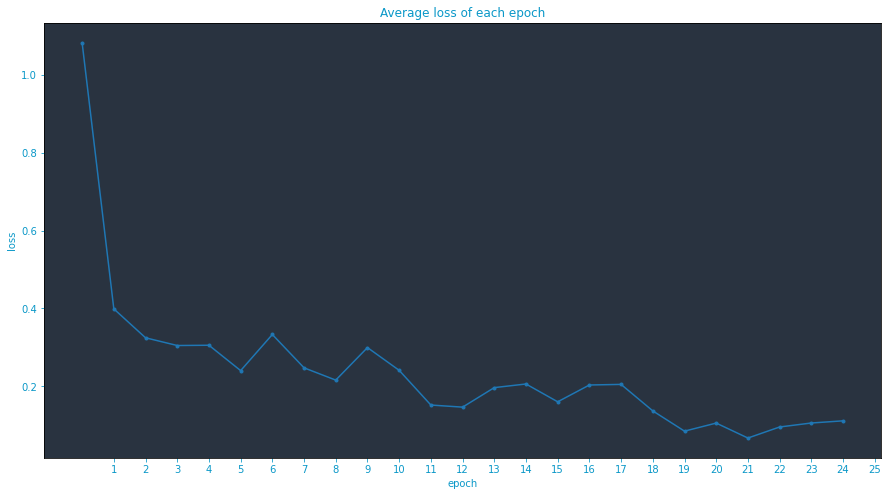

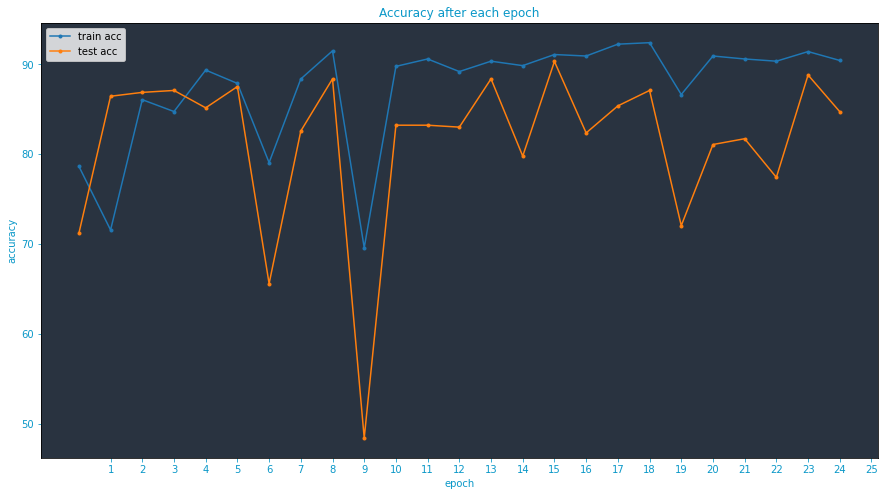

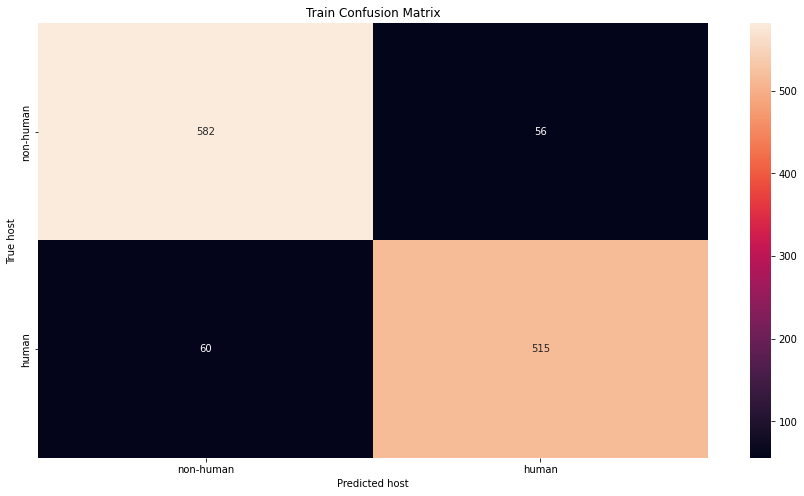

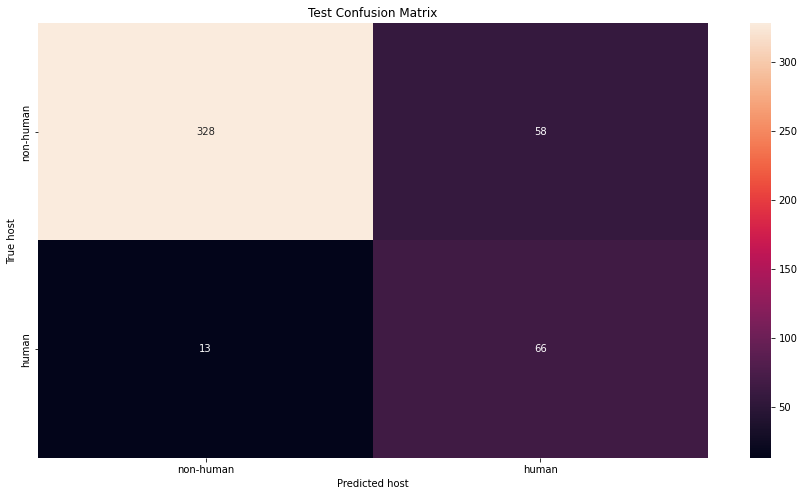

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001
conv1d_model=Conv1dNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim":100,
        "feature_size":100,
        "window_sizes":[3,5,7,9],
        "number_of_tags": 2,
        "dropout": 0.2
    }
)
conv1d_model=to_cuda(conv1d_model)

conv1d_dev_accuracies = train(conv1d_model, west_nile_train, west_nile_test, batch_size=10, epochs=25)
torch.save(conv1d_model, 'west_nile_conv1d.pth')
del conv1d_model

Legjobb Zika modellek

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.6620134206577426, 0.6202742143290206, 0.5802770105323621, 0.5500433022971265, 0.5273624608435923, 0.5352430944448792, 0.5129164400963678, 0.4923788863781651, 0.46894755208909156, 0.43588929606422816, 0.3407018480792474, 0.2710441102265447, 0.206193387309213, 0.20096491707763994, 0.174469485170513, 0.14484209008650223, 0.13445284433169036, 0.11244385007267695, 0.10081719636229991, 0.10288093993256098]


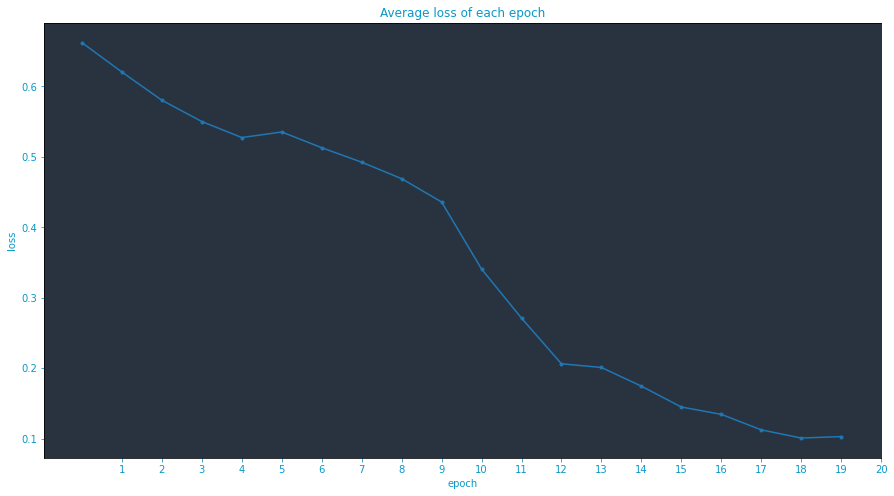

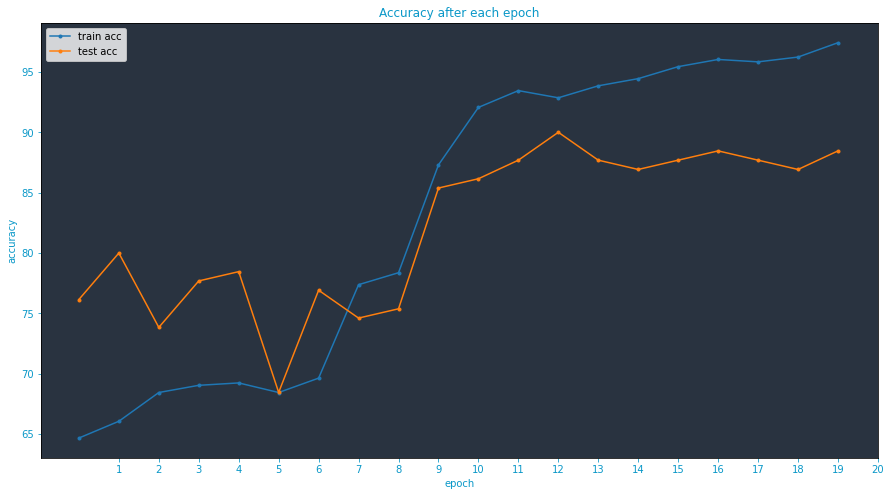

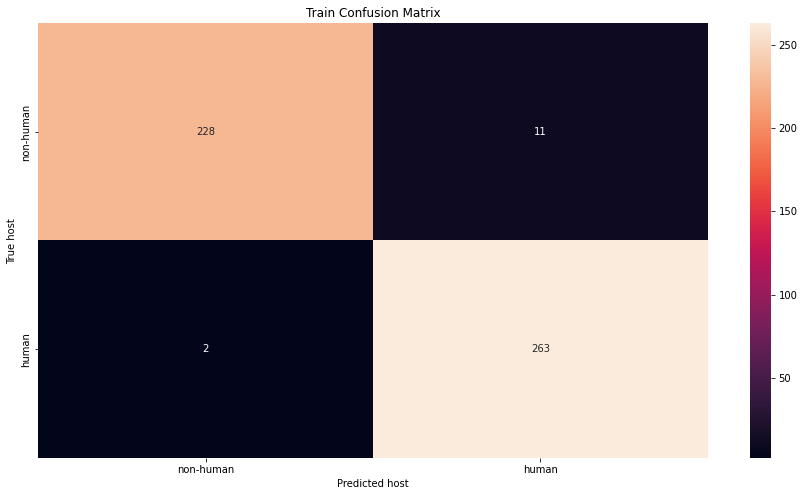

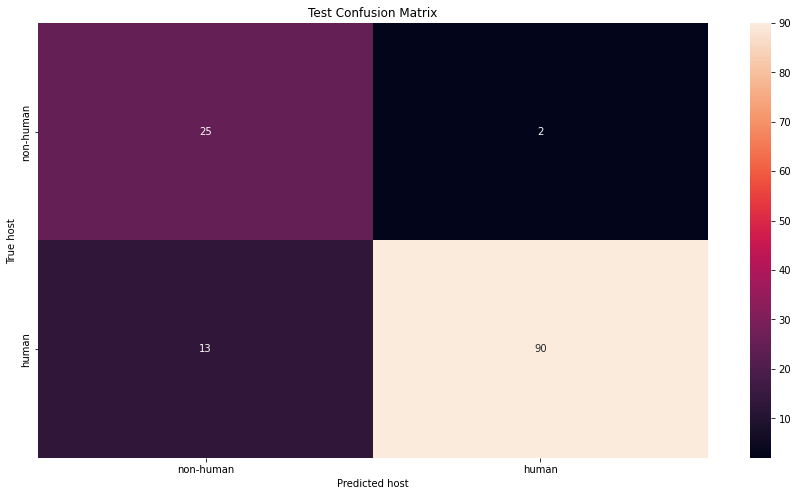

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": False
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, zika_train, zika_test, batch_size=3, epochs=20)
torch.save(lstm_model, 'zika_lstm.pth')
del lstm_model

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.6615699196145648, 0.6236183575154948, 0.5788805737642438, 0.5505463007277631, 0.5250140052701768, 0.5161683264131647, 0.4880627585676155, 0.44145364188149133, 0.35687477030331227, 0.34834096345834303, 0.38603998455454575, 0.31638984583939117, 0.2506008798982726, 0.22923178025151478, 0.2053973471535452, 0.18165130639809354, 0.16607091746040428, 0.16471521157923452, 0.14894164535146392, 0.1374106841652368]


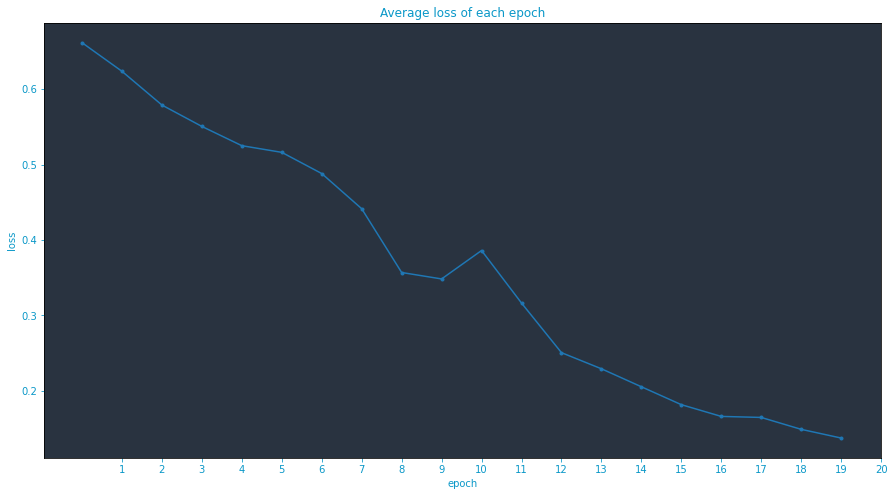

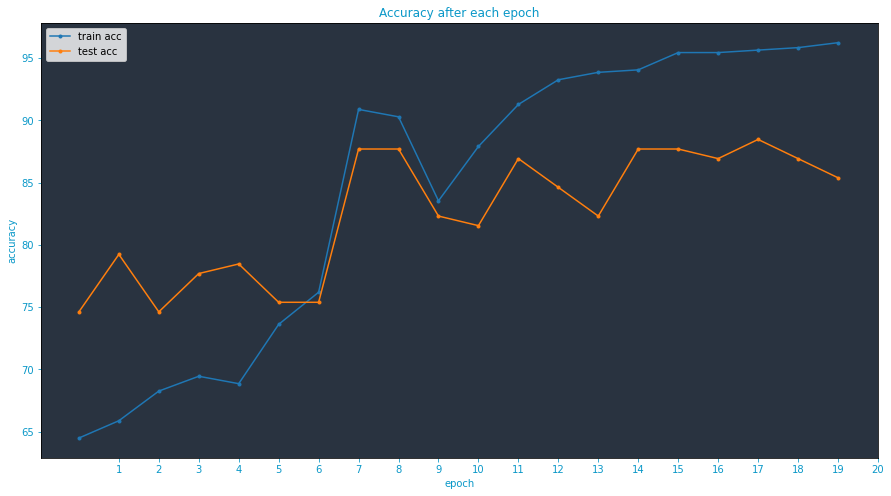

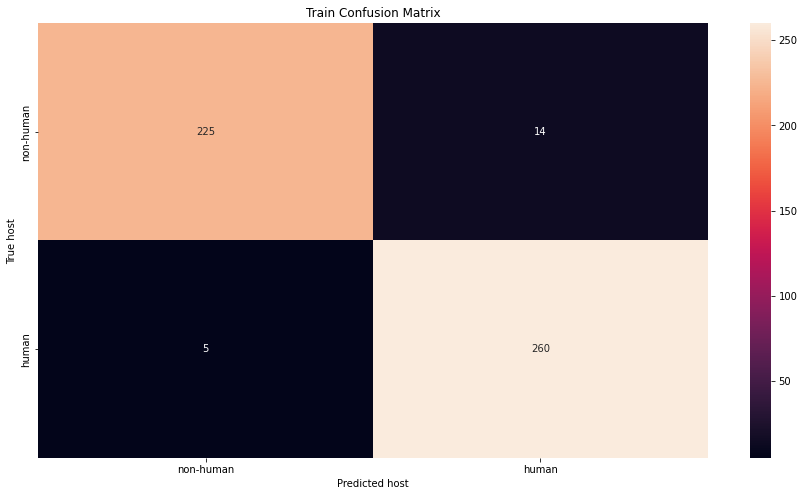

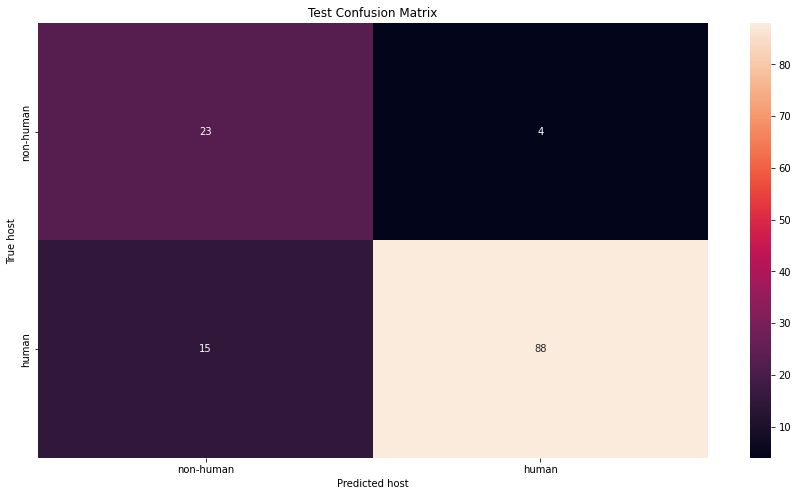

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

lstm_model=LSTMNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": True
    }
)

lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, zika_train, zika_test, batch_size=3, epochs=20)
torch.save(lstm_model, 'zika_bilstm.pth')
del lstm_model

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.6429978758096695, 0.610837964252347, 0.5729711805636596, 0.5062185882291358, 0.34016512098744334, 0.23911936421687383, 0.2006204710383567, 0.15918924464910691, 0.14448457087408834, 0.11438331926824287, 0.10881623040725008, 0.10037152482653341, 0.09437482850305623, 0.09216291319808079, 0.08947917523549959, 0.082193442645543, 0.08251209204991028, 0.082661366106073, 0.07436599257272021, 0.07527752393677171]


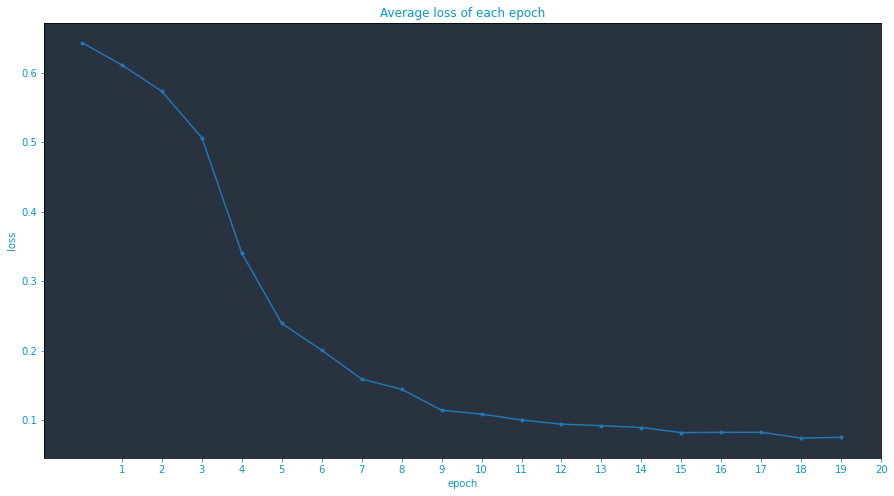

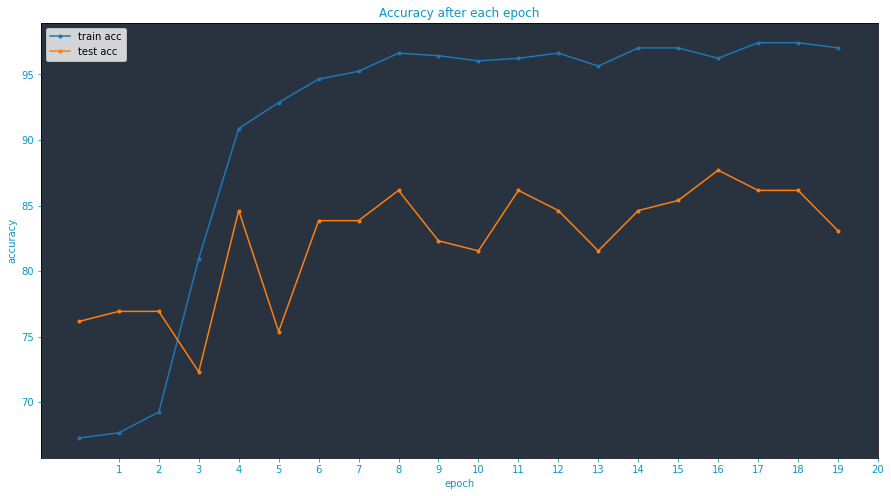

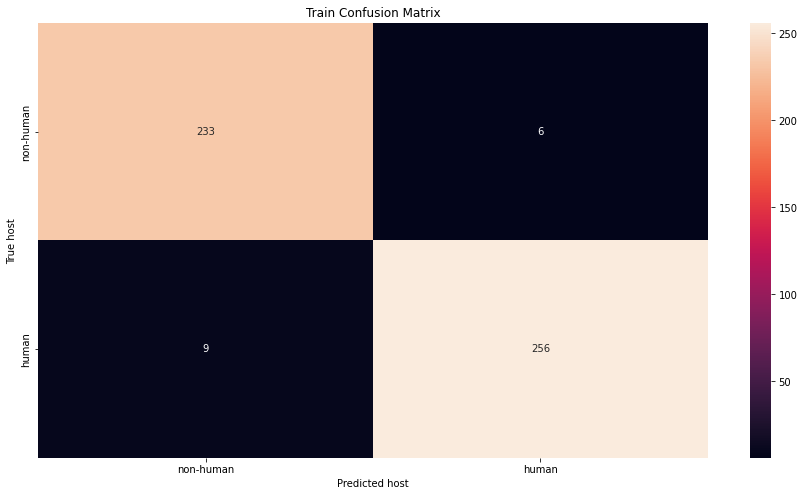

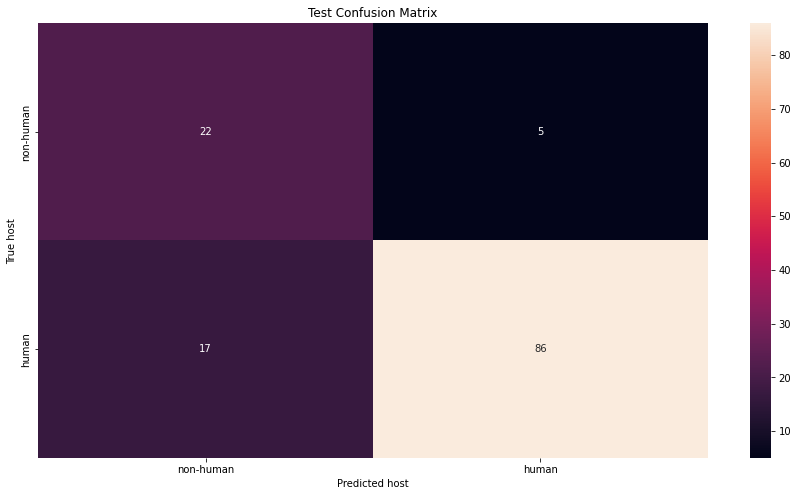

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001

gru_model=GRUNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 70,
        "gru_hidden_dim": 70,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2
    }
)
gru_model=to_cuda(gru_model)

gru_dev_accuracies = train(gru_model, zika_train, zika_test, batch_size=3, epochs=20)
torch.save(gru_model, 'zika_gru.pth')
del gru_model

  0%|          | 0/50 [00:01<?, ?it/s]

range(0, 50) [0.7636872280688424, 0.47215185137749704, 0.38134993111024024, 0.32130673869202536, 0.29079896787013804, 0.2875140404632172, 0.27145568082189475, 0.24204164126214373, 0.26900102481020094, 0.25026015219256287, 0.2543763129658709, 0.2142029402408038, 0.2663752645704725, 0.20590467332849152, 0.22723368447796452, 0.2471513324114009, 0.18686433054409418, 0.17458948596746873, 0.17323260548194716, 0.1820939530356381, 0.17057727476614154, 0.18695450871356506, 0.18498859214100993, 0.1901886720482556, 0.20022557812037467, 0.17758207473906668, 0.14159863514866325, 0.156012977755641, 0.19387490171529212, 0.18264393375535465, 0.16713629687150647, 0.22092660834599492, 0.12365167491801306, 0.15064228903433796, 0.1374641279243016, 0.1654205226296177, 0.10449880848855606, 0.11590618036600409, 0.17583753222979362, 0.082356075328118, 0.08143591264990305, 0.09027726281467385, 0.1071990275102161, 0.11539255129735336, 0.13094130773632578, 0.07995824501235152, 0.096175410697594, 0.08402495015545

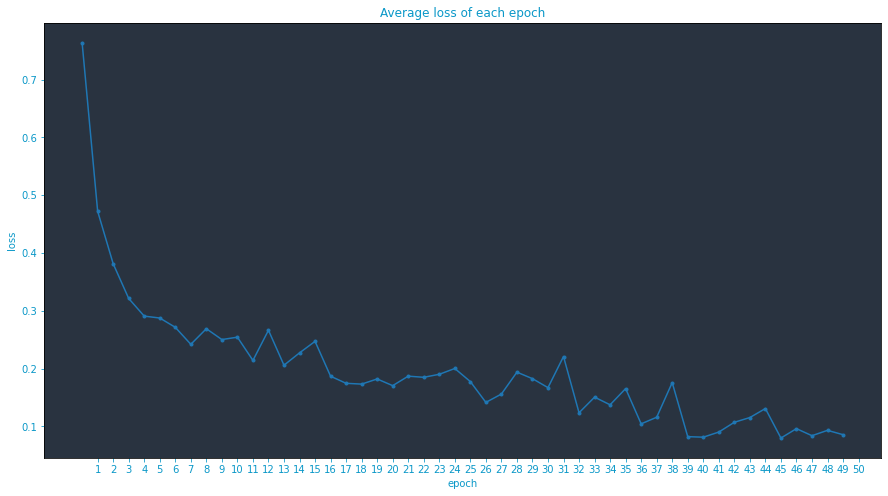

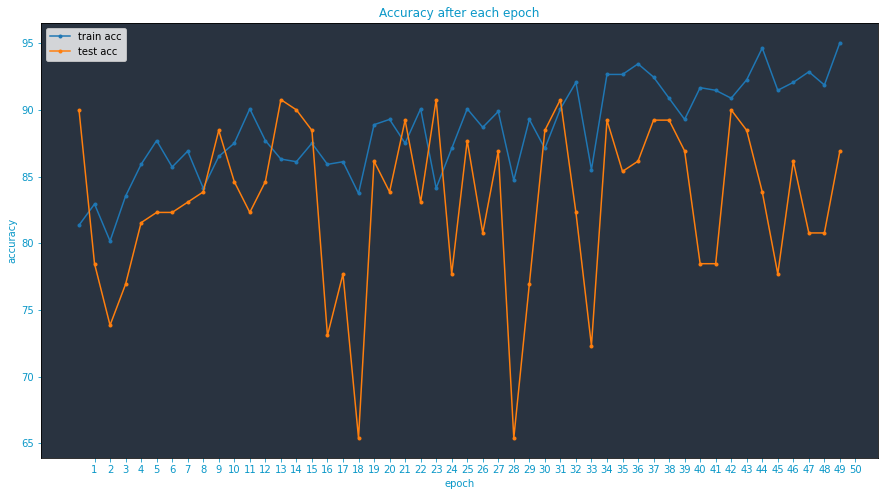

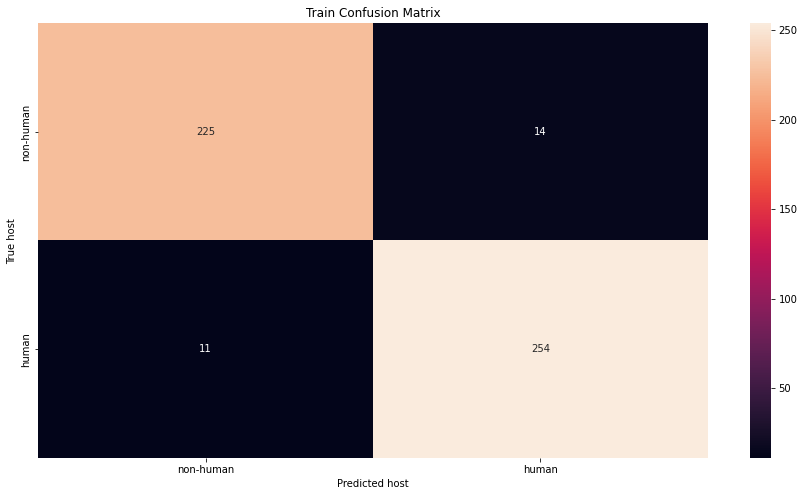

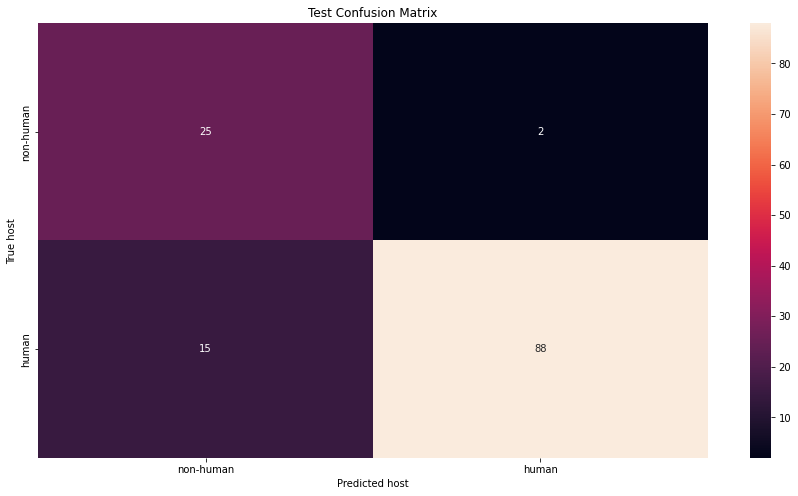

In [ ]:
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

learning_rate=0.001
conv1d_model=Conv1dNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim":50,
        "feature_size":50,
        "window_sizes":[3,5,7,9],
        "number_of_tags": 2,
        "dropout": 0.2
    }
)
conv1d_model=to_cuda(conv1d_model)

conv1d_dev_accuracies = train(conv1d_model, zika_train, zika_test, batch_size=6, epochs=50)
torch.save(conv1d_model, 'zika_conv1d.pth')
del conv1d_model

A fent beállított paraméterekkel teljesítettek legjobban a modellek. Látszik, hogy van olyan vírus, melyre jobban rá tudott tanulni mindegyik model, még másikra kevésbé.

Az eredmények alapján a legjobbnak tekintem: \
Dengue: Conv1D\
Ebola: Bi-LSTM\
MERS: LSTM\
Rota: GRU\
West-Nile: GRU\
Zika: LSTM

**Validáció**

In [29]:
def evaluate(model, valid_df, batch_size):
    model.eval()
    
    results, sentiments = get_results(model, batch_iterator(valid_df, batch_size, shuffle=False))
    acc = get_accuracy(results, sentiments)
    cm = confusion_matrix(sentiments, results)

    print("Validation accuracy is:", acc)
    plot_confusion_matrix(cm, 'Validation Confusion Matrix')
    return 


Validation accuracy is: 90.29754204398448


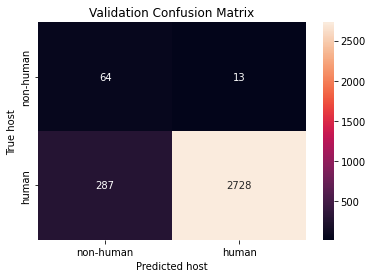

In [34]:
model = torch.load("dengue_conv1d.pth")
evaluate(model, dengue_valid, 100)
del model

Validation accuracy is: 100.0


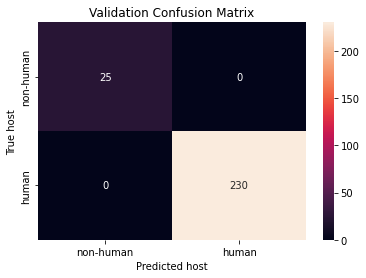

In [40]:
model = torch.load("ebola_bilstm.pth")
evaluate(model, ebola_valid, 100)
del model

Validation accuracy is: 85.49618320610686


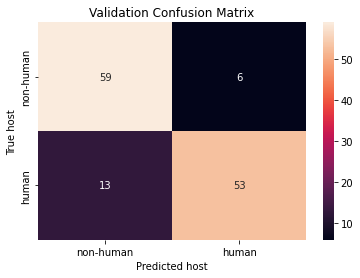

In [41]:
model = torch.load("mers_lstm.pth")
evaluate(model, mers_valid, 100)
del model

Validation accuracy is: 95.54797954477088


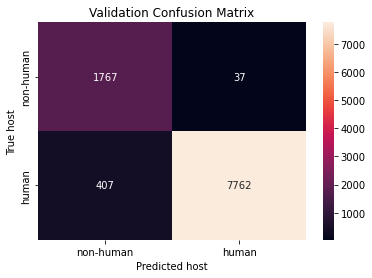

In [42]:
model = torch.load("rota_gru.pth")
evaluate(model, rota_valid, 100)
del model

Validation accuracy is: 91.82795698924731


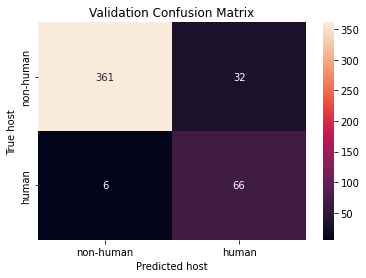

In [43]:
model = torch.load("west_nile_gru.pth")
evaluate(model, west_nile_valid, 100)
del model

Validation accuracy is: 89.23076923076924


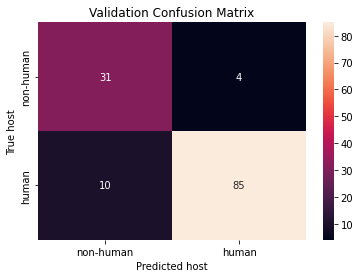

In [45]:
model = torch.load("zika_lstm.pth")
evaluate(model, zika_valid, 100)
del model

**7. Aggregált model**

In [16]:
class AggregatedModel():
    def __init__(self, model_paths):
        self.model_paths = model_paths
        self.num_models = len(model_paths)

    def get_prob(self, model, iterator):
        probs = torch.empty(0, 2)
        softmax = nn.Softmax(1)

        for input_batch, _ in iterator:
            output_batch = model(input_batch)
            probs = torch.cat((probs, softmax(output_batch).cpu()))
        return probs


    def evaluate_df(self, df, tactic):
        if tactic not in {"LinComb", "Max", "PosMax"}:
            raise ValueError("tactic param must be set to LinComb, Max or PosMax")

        probs = torch.zeros(len(df), 2)

        for path in self.model_paths:
            model = torch.load(path)
            model.eval()
            
            prob = self.get_prob(model, batch_iterator(df, 100, shuffle=False))
            
            if tactic == "LinComb":
                for i in range(0, len(df)):
                    for j in range(0, 2):
                        probs[i][j] += prob[i][j] / self.num_models

            elif tactic == "Max":
                for i in range(0, len(df)):
                    for j in range(0, 2):
                        probs[i][j] = max(probs[i][j], prob[i][j])

            else: # case tactic == "PosMax"
                for i in range(0, len(df)):
                    if prob[i][1] > 0.8:
                        probs[i][0] = 0
                        probs[i][1] = 1
                    else:
                        probs[i][0] = max(prob[i][0], probs[i][0])
                        probs[i][1] = max(prob[i][1], probs[i][1])

            del model
        
        res = classify(probs.data.cpu().numpy())
        sent = df["encoded_sentiment"].tolist()

        return res, sent

In [28]:
aggr_model = AggregatedModel(["zika_bilstm.pth", "zika_lstm.pth", "zika_gru.pth"])

res, sent = aggr_model.evaluate_df(zika_valid, tactic="LinComb")
print("LinComb acc: ", get_accuracy(res, sent))

res, sent = aggr_model.evaluate_df(zika_valid, tactic="Max")
print("Max acc: ", get_accuracy(res, sent))

res, sent = aggr_model.evaluate_df(zika_valid, tactic="PosMax")
print("PosMax acc: ", get_accuracy(res, sent))

del aggr_model

LinComb acc:  89.23076923076924
Max acc:  84.61538461538461
PosMax acc:  91.53846153846153


In [22]:
influenza_df = pd.read_csv('filtered_sequences_influenza.csv')
influenza_df['sequence_length'] = influenza_df['dna_string'].str.len()

split_len = 6
overlap = 2
influenza_df['seq_batches'] = influenza_df.apply(lambda row: [row['dna_string'][i:i+split_len] for i in range(0, row['sequence_length'], split_len-overlap)], axis=1)

influenza_df['encoded']=[word_tokenizer.encode(seq) for seq in tqdm(influenza_df['seq_batches'])]
influenza_df['encoded_length']=[len(seq) for seq in tqdm(influenza_df['seq_batches'])]

sentiment_encoding={False:0, True:1}
influenza_df['encoded_sentiment']=[sentiment_encoding[sent] for sent in tqdm(influenza_df['is_host_human'])]
influenza_df

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,dna_string,virus_id,is_host_human,sequence_length,seq_batches,encoded,encoded_length,encoded_sentiment
0,GGCATAAGCAGAGGATTTTATAACAATGGAAATAAACCCATATCTA...,7,False,2330,"[GGCATA, TAAGCA, CAGAGG, GGATTT, TTTATA, TAACA...","[893, 3940, 1624, 765, 3609, 262, 1530, 952, 2...",583,0
1,GGCATAAGCAGAGGATGTCACTACTATTAACGCTCGCAAAAGAGTA...,7,False,2364,"[GGCATA, TAAGCA, CAGAGG, GGATGT, GTCACT, CTACT...","[893, 3940, 1624, 183, 140, 212, 1877, 1046, 3...",591,0
2,GGCATAAGCAGGAGATTATTAAGCAATATGGACTCAACAAAAGCCC...,7,False,1775,"[GGCATA, TAAGCA, CAGGAG, AGATTA, TATTAA, AAGCA...","[893, 3940, 226, 620, 1877, 1115, 2410, 686, 3...",444,0
3,AGCATAAGCAGGAGATTTTCAAAGATGTTTTTGCTTCTAGCAACAA...,7,False,2049,"[AGCATA, TAAGCA, CAGGAG, AGATTT, TTTCAA, AAAGA...","[1450, 3940, 226, 63, 87, 895, 2076, 1399, 339...",513,0
4,GGCATAAGCAGGAGATTTAGAAATGTCTAGTGTAATCAGAGAAATC...,7,False,2195,"[GGCATA, TAAGCA, CAGGAG, AGATTT, TTAGAA, AAATG...","[893, 3940, 226, 63, 2716, 1943, 2722, 3670, 3...",549,0
...,...,...,...,...,...,...,...,...
1995,AGCAAAAGCAGGGTAGATAATCACTCACCGAGTGACATCAACATCA...,7,False,1565,"[AGCAAA, AAAGCA, CAGGGT, GTAGAT, ATAATC, TCACT...","[1063, 653, 959, 2695, 1989, 1811, 3036, 2802,...",392,0
1996,AGCAAAAGCAGGAGTTTGAAATGAATCCAAATCAGAAAATAATAAT...,7,False,1459,"[AGCAAA, AAAGCA, CAGGAG, AGTTTG, TGAAAT, ATGAA...","[1063, 653, 226, 1140, 55, 2652, 2348, 1337, 3...",365,0
1997,AGCAAAAGCAGGTAGATATTGAAAGATGAGTCTTCTAACCGAGGTC...,7,False,1027,"[AGCAAA, AAAGCA, CAGGTA, TAGATA, TATTGA, GAAAG...","[1063, 653, 3535, 2371, 2494, 715, 638, 914, 2...",257,0
1998,AGCAAAAGCAGGGTGACAAAAACATAATGGATTCAAACACGATAAC...,7,False,890,"[AGCAAA, AAAGCA, CAGGGT, GTGACA, CAAAAA, AACAT...","[1063, 653, 959, 666, 514, 261, 923, 549, 1788...",223,0


In [26]:
aggr_model = AggregatedModel(["dengue_bilstm.pth", "ebola_bilstm.pth",
                              "mers_lstm.pth", "rota_gru.pth",
                              "west_nile_gru.pth", "zika_lstm.pth"])

res, sent = aggr_model.evaluate_df(influenza_df, tactic="LinComb")
print("LinComb acc: ", get_accuracy(res, sent))

res, sent = aggr_model.evaluate_df(influenza_df, tactic="Max")
print("Max acc: ", get_accuracy(res, sent))

res, sent = aggr_model.evaluate_df(influenza_df, tactic="PosMax")
print("PosMax acc: ", get_accuracy(res, sent))

del aggr_model

LinComb acc:  56.45
Max acc:  64.9
PosMax acc:  40.550000000000004
